参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Sun Nov 27 19:09:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1D:00.0 Off |                    0 |
| N/A   35C    P0    40W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
#MODEL_NAME = "tf_efficientnetv2_b1"
MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

add_name = ""

In [4]:
# Parameters
add_name = "_pseudo_multioutput_freq_b5_ap"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
cfg_is_pseudo_hard = False
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
is_trn_allfold = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"kqi_3090_ex075{add_name}"
print(NAME)

kqi_3090_ex075_pseudo_multioutput_freq_b5_ap


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex007_generating_noise_nonstationary800"  # HDD 800件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

train_df.shape: (600, 22)
test_df.shape: (7975, 28)


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 28)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

add_df_all.shape: (8400, 23)


In [13]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 確信度が高い低いものだけ採用
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
    
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

pseudo_df.shape: (3501, 28)


In [14]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_pseudo_df = pd.merge(add_pseudo_df, _sum_df, on="id")

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

add_pseudo_df.shape: (796, 17)


In [15]:
#=====

In [16]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [17]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [18]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [19]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 0.9719923 -0.19701199
img.shape: (2, 360, 127)
y: 1


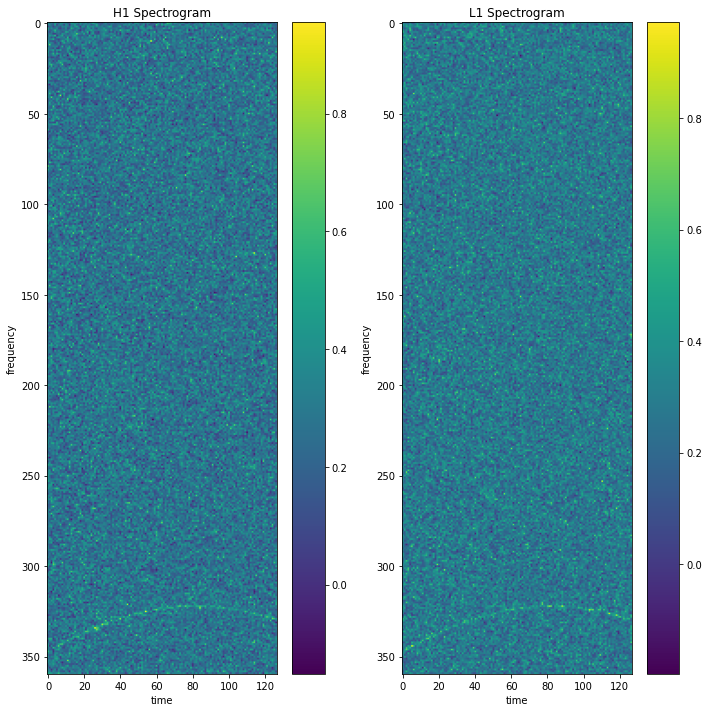

[[[0.39453262 0.20203947 0.3396818  ... 0.27632922 0.11899414 0.33444554]
  [0.2678033  0.4075403  0.23059689 ... 0.23454048 0.23039009 0.1633762 ]
  [0.08094948 0.23185672 0.2768124  ... 0.29522568 0.2629476  0.21713597]
  ...
  [0.3001728  0.28079414 0.02045513 ... 0.08754069 0.17223307 0.32373318]
  [0.33106    0.38672668 0.14893028 ... 0.38208008 0.3465088  0.05745171]
  [0.5336721  0.4740669  0.4670277  ... 0.30375433 0.3460395  0.26408148]]

 [[0.2068135  0.25157794 0.16885146 ... 0.27329373 0.2924886  0.26917318]
  [0.5539414  0.28230658 0.448552   ... 0.5220839  0.2997016  0.2909071 ]
  [0.28969613 0.26228762 0.4841211  ... 0.20905761 0.40163845 0.31956923]
  ...
  [0.19905542 0.2380448  0.09281849 ... 0.18408474 0.25636664 0.19822592]
  [0.07245706 0.36025053 0.59807014 ... 0.36116266 0.11084527 0.41722006]
  [0.17862546 0.31374174 0.24057066 ... 0.22268608 0.401473   0.3736545 ]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

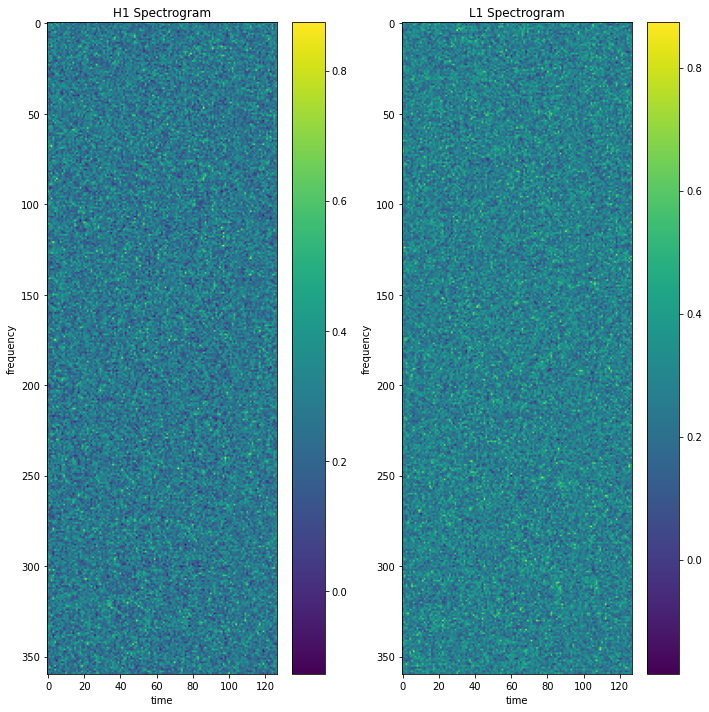

[[[0.15006506 0.33217758 0.04034983 ... 0.20706108 0.3251465  0.4728787 ]
  [0.43317902 0.32723188 0.5896392  ... 0.53872883 0.00896267 0.28693306]
  [0.33654034 0.357575   0.2975037  ... 0.41134712 0.12263454 0.31621635]
  ...
  [0.21407771 0.04740798 0.28154495 ... 0.165861   0.02190755 0.39780816]
  [0.37241173 0.34761095 0.31877738 ... 0.49716255 0.34969348 0.25458443]
  [0.14955735 0.35786584 0.07270652 ... 0.3519016  0.09932997 0.24844836]]

 [[0.4099873  0.35219115 0.1740269  ... 0.21343587 0.17007922 0.15623373]
  [0.3039274  0.37123436 0.19644742 ... 0.39971516 0.3489475  0.20918511]
  [0.50871515 0.22467804 0.3613299  ... 0.43533528 0.08122559 0.1408583 ]
  ...
  [0.23805888 0.3291553  0.29042557 ... 0.35351562 0.38016492 0.17261556]
  [0.22317521 0.34611982 0.41248098 ... 0.05895454 0.28939888 0.2547038 ]
  [0.16072243 0.22078799 0.3228265  ... 0.36343586 0.38781196 0.27864313]]]


In [20]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [21]:
#%debug

In [22]:
#=====

# To npy

In [23]:
#!rm -r {NPY_DIR}/{normalize_type}

In [24]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [25]:
#=====

# Libraries

In [26]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.0+cu117


In [27]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [28]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [29]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [30]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    #CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
    train_df = cv_split(train_df, 0, 10, cv_col="target")
    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
    print("debug train_df.shape:", train_df.shape)
    test_df = test_df.iloc[:30]
    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 50,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800]',
 'add_pseudo_dirs': '[EX007_NONSTAT_NOISE800]',
 'add_split_str': 'StratifiedKFold',
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 50,
 'freq': 360,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,
 'min_lr': 4.000000000000001e-06,
 'mix_alpha': 1.0,
 'mixup_off_epoch': 0,
 'model_cls': 'CustomModelMul

# Utils

In [31]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [32]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [33]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//10'].values - 4  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if PSEUDO_CSV != "":
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, 46+1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//10'] - 4
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, 46+1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# Transform

In [34]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [35]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 47])


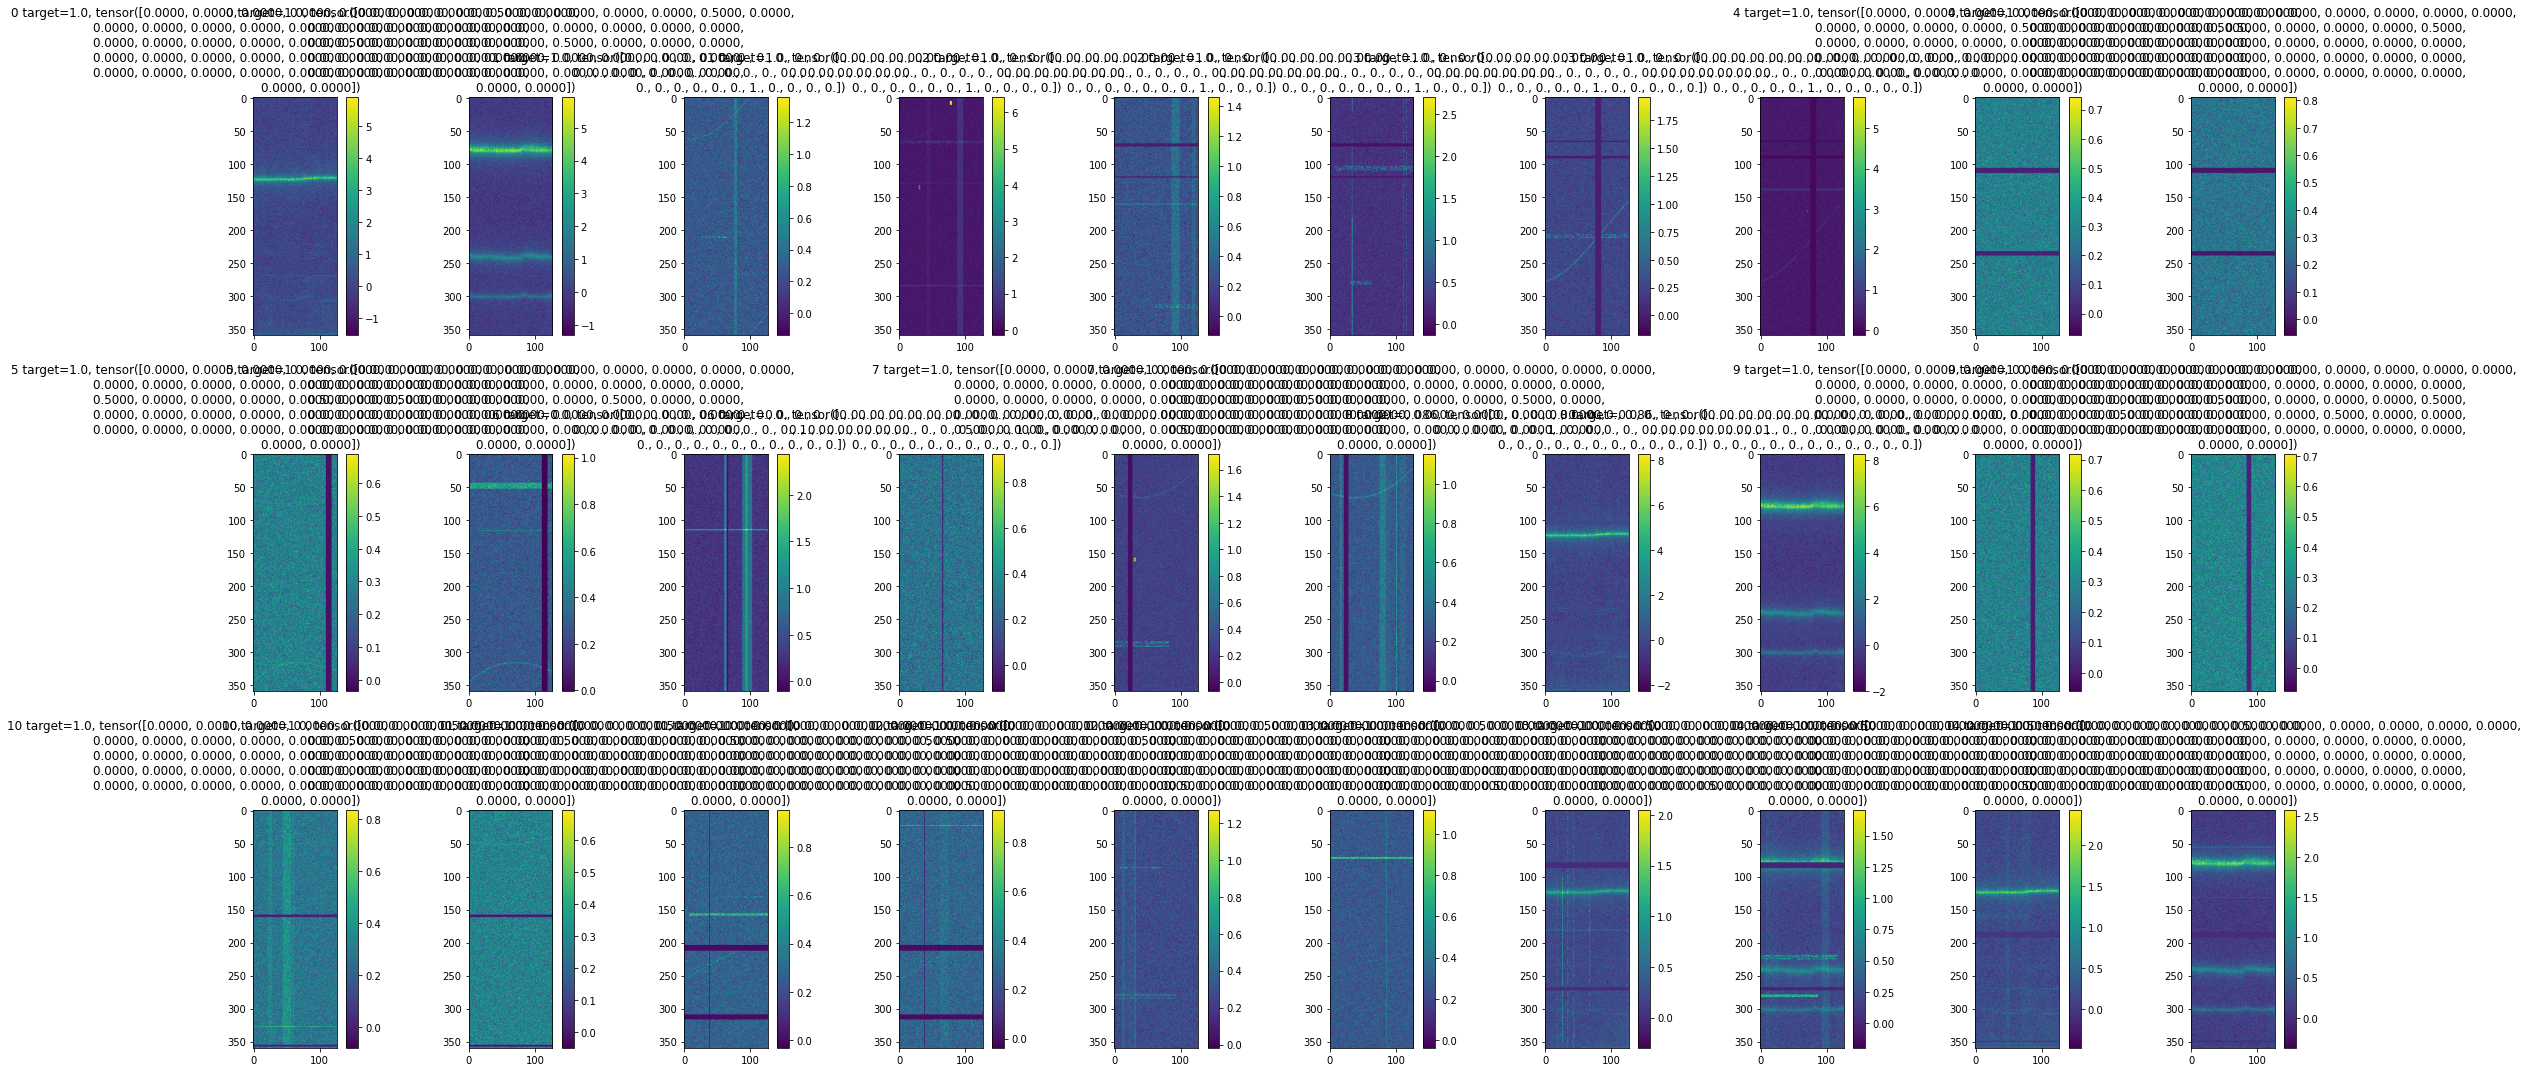

In [36]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [37]:
#=====

# Model

In [38]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [39]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [40]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, 46+1)  # 40-500Hz // 10
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [41]:
#=====

In [42]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+46+1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, 46+1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [43]:
#=====

In [44]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [45]:
#=====

In [46]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [47]:
#=====

In [48]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [49]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [50]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [51]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [52]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [53]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [54]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data='train'), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data='valid'),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [55]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (8400, 23)
pseudo_df.shape: (3501, 28)
add_pseudo_df.shape: (796, 17)


> SEEDING DONE
fold0: (1680,)
fold1: (1680,)
fold2: (1680,)
fold3: (1680,)
fold4: (1680,)
fold  target
0     0         880
      1         800
1     0         880
      1         800
2     0         880
      1         800
3     0         880
      1         800
4     0         880
      1         800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (13297, 36)
========== fold: 0, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 4s (remain 14m 4s) Loss: 2.2616(2.2616) Grad: 62668.2227  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 1m 21s (remain 0m 0s) Loss: 2.2793(2.2682) Grad: 56611.1719  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 2.2863(2.2863) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2963(2.2668) 


Epoch 1 - avg_train_loss: 2.2682  avg_val_loss: 2.2668  time: 86s
Epoch 1 - Score: 0.6376
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6376 Model
Epoch 1 - Save Best Loss: 2.2668 Model


Epoch: [2][0/179] Elapsed 0m 2s (remain 6m 31s) Loss: 2.2633(2.2633) Grad: 62111.0938  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.2030(2.2026) Grad: 67906.7891  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.2066(2.2066) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3610(2.1858) 


Epoch 2 - avg_train_loss: 2.2026  avg_val_loss: 2.1858  time: 83s
Epoch 2 - Score: 0.7943
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7943 Model
Epoch 2 - Save Best Loss: 2.1858 Model


Epoch: [3][0/179] Elapsed 0m 2s (remain 6m 32s) Loss: 2.2195(2.2195) Grad: 66411.6172  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1383(2.1707) Grad: 35317.2852  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.1759(2.1759) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3050(2.1552) 


Epoch 3 - avg_train_loss: 2.1707  avg_val_loss: 2.1552  time: 83s
Epoch 3 - Score: 0.8080
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8080 Model
Epoch 3 - Save Best Loss: 2.1552 Model


Epoch: [4][0/179] Elapsed 0m 2s (remain 6m 14s) Loss: 2.1927(2.1927) Grad: 58459.9727  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.1483(2.1610) Grad: 33316.4258  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1345(2.1345) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2217(2.1194) 


Epoch 4 - avg_train_loss: 2.1610  avg_val_loss: 2.1194  time: 83s
Epoch 4 - Score: 0.8104
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8104 Model
Epoch 4 - Save Best Loss: 2.1194 Model


Epoch: [5][0/179] Elapsed 0m 2s (remain 5m 59s) Loss: 2.1749(2.1749) Grad: 58700.3789  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.1676(2.1457) Grad: 51588.7539  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.0694(2.0694) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2010(2.0948) 


Epoch 5 - avg_train_loss: 2.1457  avg_val_loss: 2.0948  time: 83s
Epoch 5 - Score: 0.8323
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8323 Model
Epoch 5 - Save Best Loss: 2.0948 Model


Epoch: [6][0/179] Elapsed 0m 2s (remain 6m 48s) Loss: 2.1800(2.1800) Grad: 33426.6094  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1647(2.1387) Grad: 32871.8633  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2451(2.2451) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4851(2.1841) 


Epoch 6 - avg_train_loss: 2.1387  avg_val_loss: 2.1841  time: 82s
Epoch 6 - Score: 0.8215
Epoch 6 - lr: 3.9649e-04


Epoch: [7][0/179] Elapsed 0m 1s (remain 5m 53s) Loss: 2.1810(2.1810) Grad: 27422.1055  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0932(2.1347) Grad: 29434.9082  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.0856(2.0856) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2336(2.0944) 


Epoch 7 - avg_train_loss: 2.1347  avg_val_loss: 2.0944  time: 81s
Epoch 7 - Score: 0.8179
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 2.0944 Model


Epoch: [8][0/179] Elapsed 0m 2s (remain 6m 35s) Loss: 2.1338(2.1338) Grad: 29413.1270  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0851(2.1253) Grad: 26337.0957  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1556(2.1556) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2106(2.1127) 


Epoch 8 - avg_train_loss: 2.1253  avg_val_loss: 2.1127  time: 82s
Epoch 8 - Score: 0.8204
Epoch 8 - lr: 3.9031e-04


Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 42s) Loss: 2.1766(2.1766) Grad: 40799.4141  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1977(2.1269) Grad: 24154.9102  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0770(2.0770) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2870(2.0985) 


Epoch 9 - avg_train_loss: 2.1269  avg_val_loss: 2.0985  time: 82s
Epoch 9 - Score: 0.8218
Epoch 9 - lr: 3.8610e-04


Epoch: [10][0/179] Elapsed 0m 2s (remain 7m 24s) Loss: 2.1771(2.1771) Grad: 29974.0293  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.1280(2.1189) Grad: 45524.0430  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0197(2.0197) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2157(2.0789) 


Epoch 10 - avg_train_loss: 2.1189  avg_val_loss: 2.0789  time: 84s
Epoch 10 - Score: 0.8286
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Loss: 2.0789 Model


Epoch: [11][0/179] Elapsed 0m 2s (remain 6m 57s) Loss: 2.1738(2.1738) Grad: 34013.0859  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0497(2.1133) Grad: 22436.0742  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2193(2.2193) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2569(2.1298) 


Epoch 11 - avg_train_loss: 2.1133  avg_val_loss: 2.1298  time: 82s
Epoch 11 - Score: 0.8329
Epoch 11 - lr: 3.7551e-04
Epoch 11 - Save Best Score: 0.8329 Model


Epoch: [12][0/179] Elapsed 0m 2s (remain 6m 45s) Loss: 2.0459(2.0459) Grad: 19868.2500  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1226(2.1142) Grad: 22806.6113  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0662(2.0662) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1977(2.0850) 


Epoch 12 - avg_train_loss: 2.1142  avg_val_loss: 2.0850  time: 82s
Epoch 12 - Score: 0.8304
Epoch 12 - lr: 3.6918e-04


Epoch: [13][0/179] Elapsed 0m 2s (remain 7m 12s) Loss: 2.1323(2.1323) Grad: 20414.1211  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0936(2.1100) Grad: 25090.7168  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0678(2.0678) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1168(2.0622) 


Epoch 13 - avg_train_loss: 2.1100  avg_val_loss: 2.0622  time: 82s
Epoch 13 - Score: 0.8404
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8404 Model
Epoch 13 - Save Best Loss: 2.0622 Model


Epoch: [14][0/179] Elapsed 0m 2s (remain 8m 8s) Loss: 2.1335(2.1335) Grad: 22881.5977  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1458(2.1104) Grad: 53998.3438  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0131(2.0131) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1339(2.0623) 


Epoch 14 - avg_train_loss: 2.1104  avg_val_loss: 2.0623  time: 82s
Epoch 14 - Score: 0.8306
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/179] Elapsed 0m 2s (remain 7m 1s) Loss: 2.1102(2.1102) Grad: 21460.0137  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1218(2.1090) Grad: 18639.3262  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0220(2.0220) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1337(2.0583) 


Epoch 15 - avg_train_loss: 2.1090  avg_val_loss: 2.0583  time: 82s
Epoch 15 - Score: 0.8414
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Score: 0.8414 Model
Epoch 15 - Save Best Loss: 2.0583 Model


Epoch: [16][0/179] Elapsed 0m 1s (remain 5m 28s) Loss: 2.0367(2.0367) Grad: 21703.2383  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1105(2.0990) Grad: 29411.6797  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1556(2.1556) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1251(2.0793) 


Epoch 16 - avg_train_loss: 2.0990  avg_val_loss: 2.0793  time: 81s
Epoch 16 - Score: 0.8320
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/179] Elapsed 0m 2s (remain 6m 46s) Loss: 2.1284(2.1284) Grad: 23303.3008  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1159(2.0967) Grad: 27409.2656  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.0424(2.0424) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0972(2.0480) 


Epoch 17 - avg_train_loss: 2.0967  avg_val_loss: 2.0480  time: 82s
Epoch 17 - Score: 0.8440
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Score: 0.8440 Model
Epoch 17 - Save Best Loss: 2.0480 Model


Epoch: [18][0/179] Elapsed 0m 2s (remain 6m 41s) Loss: 2.1273(2.1273) Grad: 26925.5391  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.1178(2.0975) Grad: 22001.2480  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0484(2.0484) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0542(2.0629) 


Epoch 18 - avg_train_loss: 2.0975  avg_val_loss: 2.0629  time: 84s
Epoch 18 - Score: 0.8277
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/179] Elapsed 0m 2s (remain 6m 58s) Loss: 2.0656(2.0656) Grad: 22432.8145  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0674(2.1061) Grad: 11336.8838  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0256(2.0256) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1587(2.0671) 


Epoch 19 - avg_train_loss: 2.1061  avg_val_loss: 2.0671  time: 82s
Epoch 19 - Score: 0.8470
Epoch 19 - lr: 3.0809e-04
Epoch 19 - Save Best Score: 0.8470 Model


Epoch: [20][0/179] Elapsed 0m 2s (remain 6m 37s) Loss: 2.1683(2.1683) Grad: 23189.9648  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0593(2.0954) Grad: 22308.7246  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0214(2.0214) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0881(2.0528) 


Epoch 20 - avg_train_loss: 2.0954  avg_val_loss: 2.0528  time: 81s
Epoch 20 - Score: 0.8370
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/179] Elapsed 0m 2s (remain 6m 0s) Loss: 2.0777(2.0777) Grad: 23782.5879  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0702(2.0910) Grad: 20365.0312  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0611(2.0611) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1055(2.0463) 


Epoch 21 - avg_train_loss: 2.0910  avg_val_loss: 2.0463  time: 81s
Epoch 21 - Score: 0.8328
Epoch 21 - lr: 2.8630e-04
Epoch 21 - Save Best Loss: 2.0463 Model


Epoch: [22][0/179] Elapsed 0m 2s (remain 6m 51s) Loss: 2.0496(2.0496) Grad: 21219.2207  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0728(2.0931) Grad: 24942.6328  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0171(2.0171) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0433(2.0679) 


Epoch 22 - avg_train_loss: 2.0931  avg_val_loss: 2.0679  time: 81s
Epoch 22 - Score: 0.8401
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/179] Elapsed 0m 2s (remain 6m 18s) Loss: 2.0933(2.0933) Grad: 22089.4219  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.0695(2.0826) Grad: 34686.2500  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0069(2.0069) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1170(2.0471) 


Epoch 23 - avg_train_loss: 2.0826  avg_val_loss: 2.0471  time: 84s
Epoch 23 - Score: 0.8445
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/179] Elapsed 0m 2s (remain 6m 36s) Loss: 2.1071(2.1071) Grad: 27756.5430  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1156(2.0845) Grad: 24616.4199  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.0008(2.0008) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.9521(2.0544) 


Epoch 24 - avg_train_loss: 2.0845  avg_val_loss: 2.0544  time: 82s
Epoch 24 - Score: 0.8472
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Score: 0.8472 Model


Epoch: [25][0/179] Elapsed 0m 2s (remain 6m 51s) Loss: 2.0487(2.0487) Grad: 23216.6562  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1175(2.0833) Grad: 23572.3613  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0403(2.0403) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0007(2.0603) 


Epoch 25 - avg_train_loss: 2.0833  avg_val_loss: 2.0603  time: 81s
Epoch 25 - Score: 0.8412
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/179] Elapsed 0m 2s (remain 6m 45s) Loss: 2.0776(2.0776) Grad: 22485.4961  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0548(2.0798) Grad: 29666.9531  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0378(2.0378) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0050(2.0671) 


Epoch 26 - avg_train_loss: 2.0798  avg_val_loss: 2.0671  time: 81s
Epoch 26 - Score: 0.8428
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/179] Elapsed 0m 1s (remain 5m 40s) Loss: 2.0434(2.0434) Grad: 26883.9531  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0203(2.0798) Grad: 20858.3906  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0048(2.0048) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0320(2.0548) 


Epoch 27 - avg_train_loss: 2.0798  avg_val_loss: 2.0548  time: 80s
Epoch 27 - Score: 0.8415
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/179] Elapsed 0m 2s (remain 6m 20s) Loss: 2.0781(2.0781) Grad: 25719.1660  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0624(2.0812) Grad: 25356.6582  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0762(2.0762) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0586(2.0577) 


Epoch 28 - avg_train_loss: 2.0812  avg_val_loss: 2.0577  time: 81s
Epoch 28 - Score: 0.8272
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/179] Elapsed 0m 2s (remain 7m 19s) Loss: 2.0699(2.0699) Grad: 50250.1133  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0899(2.0793) Grad: 30616.4277  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0407(2.0407) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1017(2.0859) 


Epoch 29 - avg_train_loss: 2.0793  avg_val_loss: 2.0859  time: 81s
Epoch 29 - Score: 0.8203
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/179] Elapsed 0m 2s (remain 7m 50s) Loss: 2.1333(2.1333) Grad: 30719.7383  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0621(2.0724) Grad: 28826.8945  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0230(2.0230) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1152(2.0679) 


Epoch 30 - avg_train_loss: 2.0724  avg_val_loss: 2.0679  time: 82s
Epoch 30 - Score: 0.8341
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/179] Elapsed 0m 2s (remain 6m 3s) Loss: 2.0627(2.0627) Grad: 31406.3164  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0565(2.0757) Grad: 34443.4766  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0487(2.0487) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0757(2.0549) 


Epoch 31 - avg_train_loss: 2.0757  avg_val_loss: 2.0549  time: 81s
Epoch 31 - Score: 0.8369
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/179] Elapsed 0m 2s (remain 7m 10s) Loss: 2.0932(2.0932) Grad: 35948.6562  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0187(2.0686) Grad: 28104.8809  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0501(2.0501) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1397(2.0524) 


Epoch 32 - avg_train_loss: 2.0686  avg_val_loss: 2.0524  time: 83s
Epoch 32 - Score: 0.8422
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/179] Elapsed 0m 2s (remain 6m 1s) Loss: 2.0538(2.0538) Grad: 31743.2676  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0208(2.0659) Grad: 23728.1133  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0914(2.0914) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1244(2.0543) 


Epoch 33 - avg_train_loss: 2.0659  avg_val_loss: 2.0543  time: 82s
Epoch 33 - Score: 0.8294
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/179] Elapsed 0m 2s (remain 6m 56s) Loss: 2.1075(2.1075) Grad: 25979.0879  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1040(2.0621) Grad: 27160.2754  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0573(2.0573) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0694(2.0894) 


Epoch 34 - avg_train_loss: 2.0621  avg_val_loss: 2.0894  time: 82s
Epoch 34 - Score: 0.8154
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/179] Elapsed 0m 2s (remain 6m 59s) Loss: 2.0714(2.0714) Grad: 30051.9277  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0686(2.0631) Grad: 40357.9141  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0675(2.0675) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1714(2.0587) 


Epoch 35 - avg_train_loss: 2.0631  avg_val_loss: 2.0587  time: 81s
Epoch 35 - Score: 0.8378
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/179] Elapsed 0m 2s (remain 6m 38s) Loss: 2.0106(2.0106) Grad: 24661.9180  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1024(2.0578) Grad: 33606.1797  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1467(2.1467) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2637(2.0767) 


Epoch 36 - avg_train_loss: 2.0578  avg_val_loss: 2.0767  time: 81s
Epoch 36 - Score: 0.8395
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/179] Elapsed 0m 1s (remain 5m 11s) Loss: 2.0367(2.0367) Grad: 26660.8633  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0680(2.0586) Grad: 30885.4473  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1323(2.1323) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2592(2.0668) 


Epoch 37 - avg_train_loss: 2.0586  avg_val_loss: 2.0668  time: 81s
Epoch 37 - Score: 0.8409
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/179] Elapsed 0m 2s (remain 7m 5s) Loss: 2.0469(2.0469) Grad: 33330.0000  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0476(2.0555) Grad: 29606.2617  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.0510(2.0510) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0919(2.0586) 


Epoch 38 - avg_train_loss: 2.0555  avg_val_loss: 2.0586  time: 81s
Epoch 38 - Score: 0.8358
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 2.0204(2.0204) Grad: 26716.4199  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1043(2.0558) Grad: 38717.0391  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1343(2.1343) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4111(2.0645) 


Epoch 39 - avg_train_loss: 2.0558  avg_val_loss: 2.0645  time: 82s
Epoch 39 - Score: 0.8388
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/179] Elapsed 0m 2s (remain 7m 35s) Loss: 2.1011(2.1011) Grad: 27767.5996  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0378(2.0557) Grad: 26315.1074  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0616(2.0616) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1986(2.0829) 


Epoch 40 - avg_train_loss: 2.0557  avg_val_loss: 2.0829  time: 82s
Epoch 40 - Score: 0.8244
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/179] Elapsed 0m 2s (remain 6m 39s) Loss: 2.0342(2.0342) Grad: 38447.3125  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0160(2.0506) Grad: 24935.3574  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1254(2.1254) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2539(2.0611) 


Epoch 41 - avg_train_loss: 2.0506  avg_val_loss: 2.0611  time: 82s
Epoch 41 - Score: 0.8394
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/179] Elapsed 0m 2s (remain 7m 47s) Loss: 2.0559(2.0559) Grad: 34110.4609  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0592(2.0434) Grad: 15210.9443  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1410(2.1410) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2674(2.0723) 


Epoch 42 - avg_train_loss: 2.0434  avg_val_loss: 2.0723  time: 82s
Epoch 42 - Score: 0.8374
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/179] Elapsed 0m 2s (remain 7m 28s) Loss: 2.1063(2.1063) Grad: 36871.0586  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0317(2.0476) Grad: 32237.7852  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0728(2.0728) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2568(2.0597) 


Epoch 43 - avg_train_loss: 2.0476  avg_val_loss: 2.0597  time: 82s
Epoch 43 - Score: 0.8379
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/179] Elapsed 0m 2s (remain 7m 31s) Loss: 2.0753(2.0753) Grad: 30575.3848  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0702(2.0499) Grad: 29213.4277  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0998(2.0998) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3476(2.0608) 


Epoch 44 - avg_train_loss: 2.0499  avg_val_loss: 2.0608  time: 81s
Epoch 44 - Score: 0.8378
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/179] Elapsed 0m 2s (remain 7m 5s) Loss: 2.1213(2.1213) Grad: 36757.7578  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 1.9783(2.0459) Grad: 27835.9316  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1376(2.1376) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3352(2.0671) 


Epoch 45 - avg_train_loss: 2.0459  avg_val_loss: 2.0671  time: 81s
Epoch 45 - Score: 0.8397
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/179] Elapsed 0m 2s (remain 6m 1s) Loss: 2.0430(2.0430) Grad: 39218.6016  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0864(2.0437) Grad: 40091.0859  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.1215(2.1215) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2869(2.0593) 


Epoch 46 - avg_train_loss: 2.0437  avg_val_loss: 2.0593  time: 81s
Epoch 46 - Score: 0.8387
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/179] Elapsed 0m 2s (remain 6m 24s) Loss: 1.9753(1.9753) Grad: 29531.1328  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0955(2.0377) Grad: 39485.7266  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1038(2.1038) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3243(2.0651) 


Epoch 47 - avg_train_loss: 2.0377  avg_val_loss: 2.0651  time: 81s
Epoch 47 - Score: 0.8399
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/179] Elapsed 0m 2s (remain 7m 24s) Loss: 1.9970(1.9970) Grad: 27536.9043  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0985(2.0389) Grad: 39389.9297  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1419(2.1419) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3692(2.0712) 


Epoch 48 - avg_train_loss: 2.0389  avg_val_loss: 2.0712  time: 81s
Epoch 48 - Score: 0.8368
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/179] Elapsed 0m 2s (remain 6m 8s) Loss: 2.0059(2.0059) Grad: 30057.1250  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1591(2.0361) Grad: 37571.2070  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1490(2.1490) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4271(2.0870) 


Epoch 49 - avg_train_loss: 2.0361  avg_val_loss: 2.0870  time: 81s
Epoch 49 - Score: 0.8384
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/179] Elapsed 0m 2s (remain 7m 37s) Loss: 1.9676(1.9676) Grad: 35164.3398  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 1.9705(2.0385) Grad: 38177.6992  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1074(2.1074) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3355(2.0605) 


Epoch 50 - avg_train_loss: 2.0385  avg_val_loss: 2.0605  time: 81s
Epoch 50 - Score: 0.8385
Epoch 50 - lr: 7.5071e-06
========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8472
========== fold: 1, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 2.2790(2.2790) Grad: 57437.7500  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.2575(2.2698) Grad: 64498.3516  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2912(2.2912) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3193(2.2706) 


Epoch 1 - avg_train_loss: 2.2698  avg_val_loss: 2.2706  time: 81s
Epoch 1 - Score: 0.6436
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6436 Model
Epoch 1 - Save Best Loss: 2.2706 Model


Epoch: [2][0/179] Elapsed 0m 2s (remain 7m 30s) Loss: 2.2609(2.2609) Grad: 62524.2539  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1889(2.2067) Grad: 63976.0938  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.3420(2.3420) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1508(2.2316) 


Epoch 2 - avg_train_loss: 2.2067  avg_val_loss: 2.2316  time: 82s
Epoch 2 - Score: 0.7736
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7736 Model
Epoch 2 - Save Best Loss: 2.2316 Model


Epoch: [3][0/179] Elapsed 0m 2s (remain 7m 20s) Loss: 2.1806(2.1806) Grad: 67762.9922  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1624(2.1743) Grad: 34222.1953  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1690(2.1690) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1033(2.1257) 


Epoch 3 - avg_train_loss: 2.1743  avg_val_loss: 2.1257  time: 82s
Epoch 3 - Score: 0.8270
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8270 Model
Epoch 3 - Save Best Loss: 2.1257 Model


Epoch: [4][0/179] Elapsed 0m 2s (remain 7m 2s) Loss: 2.2006(2.2006) Grad: 40610.7539  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1692(2.1586) Grad: 34244.3750  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1326(2.1326) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0751(2.1133) 


Epoch 4 - avg_train_loss: 2.1586  avg_val_loss: 2.1133  time: 82s
Epoch 4 - Score: 0.8155
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Loss: 2.1133 Model


Epoch: [5][0/179] Elapsed 0m 2s (remain 6m 18s) Loss: 2.1452(2.1452) Grad: 24128.1055  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1687(2.1469) Grad: 36025.0273  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1928(2.1928) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3397(2.1248) 


Epoch 5 - avg_train_loss: 2.1469  avg_val_loss: 2.1248  time: 82s
Epoch 5 - Score: 0.8226
Epoch 5 - lr: 3.9844e-04


Epoch: [6][0/179] Elapsed 0m 2s (remain 6m 41s) Loss: 2.1173(2.1173) Grad: 34016.9297  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1723(2.1352) Grad: 31222.7734  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1696(2.1696) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1612(2.1036) 


Epoch 6 - avg_train_loss: 2.1352  avg_val_loss: 2.1036  time: 82s
Epoch 6 - Score: 0.8135
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Loss: 2.1036 Model


Epoch: [7][0/179] Elapsed 0m 2s (remain 6m 47s) Loss: 2.1662(2.1662) Grad: 52553.7695  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1525(2.1313) Grad: 38132.5469  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1166(2.1166) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1679(2.0798) 


Epoch 7 - avg_train_loss: 2.1313  avg_val_loss: 2.0798  time: 81s
Epoch 7 - Score: 0.8449
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Score: 0.8449 Model
Epoch 7 - Save Best Loss: 2.0798 Model


Epoch: [8][0/179] Elapsed 0m 2s (remain 6m 49s) Loss: 2.1431(2.1431) Grad: 34198.4609  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1160(2.1293) Grad: 47497.8203  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0977(2.0977) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0486(2.0756) 


Epoch 8 - avg_train_loss: 2.1293  avg_val_loss: 2.0756  time: 83s
Epoch 8 - Score: 0.8396
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Loss: 2.0756 Model


Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 52s) Loss: 2.1030(2.1030) Grad: 24037.9668  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1556(2.1229) Grad: 26666.6719  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0806(2.0806) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0416(2.0634) 


Epoch 9 - avg_train_loss: 2.1229  avg_val_loss: 2.0634  time: 82s
Epoch 9 - Score: 0.8298
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Loss: 2.0634 Model


Epoch: [10][0/179] Elapsed 0m 2s (remain 6m 44s) Loss: 2.1305(2.1305) Grad: 26321.1152  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0962(2.1200) Grad: 31088.3262  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2836(2.2836) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0996(2.1360) 


Epoch 10 - avg_train_loss: 2.1200  avg_val_loss: 2.1360  time: 82s
Epoch 10 - Score: 0.8294
Epoch 10 - lr: 3.8116e-04


Epoch: [11][0/179] Elapsed 0m 2s (remain 6m 40s) Loss: 2.1575(2.1575) Grad: 50804.2930  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1012(2.1144) Grad: 22379.2539  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1675(2.1675) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0545(2.0798) 


Epoch 11 - avg_train_loss: 2.1144  avg_val_loss: 2.0798  time: 82s
Epoch 11 - Score: 0.8238
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/179] Elapsed 0m 2s (remain 6m 35s) Loss: 2.1247(2.1247) Grad: 26701.0977  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1186(2.1156) Grad: 40152.8086  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1724(2.1724) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0765(2.0684) 


Epoch 12 - avg_train_loss: 2.1156  avg_val_loss: 2.0684  time: 82s
Epoch 12 - Score: 0.8290
Epoch 12 - lr: 3.6918e-04


Epoch: [13][0/179] Elapsed 0m 2s (remain 7m 35s) Loss: 2.1504(2.1504) Grad: 27767.2402  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0732(2.1130) Grad: 28531.5781  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2179(2.2179) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1485(2.0916) 


Epoch 13 - avg_train_loss: 2.1130  avg_val_loss: 2.0916  time: 82s
Epoch 13 - Score: 0.8219
Epoch 13 - lr: 3.6219e-04


Epoch: [14][0/179] Elapsed 0m 2s (remain 6m 33s) Loss: 2.1076(2.1076) Grad: 22967.7344  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0653(2.1072) Grad: 36193.5703  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0842(2.0842) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1272(2.0720) 


Epoch 14 - avg_train_loss: 2.1072  avg_val_loss: 2.0720  time: 82s
Epoch 14 - Score: 0.8168
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/179] Elapsed 0m 2s (remain 6m 4s) Loss: 2.0899(2.0899) Grad: 33358.1211  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0643(2.1047) Grad: 24894.3008  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1993(2.1993) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0099(2.0681) 


Epoch 15 - avg_train_loss: 2.1047  avg_val_loss: 2.0681  time: 82s
Epoch 15 - Score: 0.8151
Epoch 15 - lr: 3.4634e-04


Epoch: [16][0/179] Elapsed 0m 2s (remain 8m 7s) Loss: 2.1211(2.1211) Grad: 34633.3477  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0837(2.1010) Grad: 20861.4570  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1529(2.1529) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1843(2.0691) 


Epoch 16 - avg_train_loss: 2.1010  avg_val_loss: 2.0691  time: 82s
Epoch 16 - Score: 0.8303
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/179] Elapsed 0m 2s (remain 7m 15s) Loss: 2.1154(2.1154) Grad: 24613.6113  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0928(2.1025) Grad: 27086.7246  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0355(2.0355) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0370(2.0586) 


Epoch 17 - avg_train_loss: 2.1025  avg_val_loss: 2.0586  time: 82s
Epoch 17 - Score: 0.8483
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Score: 0.8483 Model
Epoch 17 - Save Best Loss: 2.0586 Model


Epoch: [18][0/179] Elapsed 0m 1s (remain 5m 28s) Loss: 2.0561(2.0561) Grad: 20453.9336  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.1135(2.0950) Grad: 51700.0156  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0957(2.0957) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0175(2.0635) 


Epoch 18 - avg_train_loss: 2.0950  avg_val_loss: 2.0635  time: 80s
Epoch 18 - Score: 0.8299
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/179] Elapsed 0m 2s (remain 6m 56s) Loss: 2.0502(2.0502) Grad: 24171.1133  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1347(2.0919) Grad: 27499.2461  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1260(2.1260) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0610(2.0510) 


Epoch 19 - avg_train_loss: 2.0919  avg_val_loss: 2.0510  time: 82s
Epoch 19 - Score: 0.8299
Epoch 19 - lr: 3.0809e-04
Epoch 19 - Save Best Loss: 2.0510 Model


Epoch: [20][0/179] Elapsed 0m 2s (remain 7m 47s) Loss: 2.0916(2.0916) Grad: 26718.4590  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1327(2.0930) Grad: 47955.4883  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1143(2.1143) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.9720(2.0549) 


Epoch 20 - avg_train_loss: 2.0930  avg_val_loss: 2.0549  time: 82s
Epoch 20 - Score: 0.8326
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/179] Elapsed 0m 2s (remain 8m 22s) Loss: 2.1057(2.1057) Grad: 33090.1914  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1047(2.0900) Grad: 26276.3848  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0996(2.0996) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0960(2.0620) 


Epoch 21 - avg_train_loss: 2.0900  avg_val_loss: 2.0620  time: 82s
Epoch 21 - Score: 0.8265
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/179] Elapsed 0m 2s (remain 7m 12s) Loss: 2.0631(2.0631) Grad: 28896.4414  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0812(2.0901) Grad: 22778.6289  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0679(2.0679) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0518(2.0729) 


Epoch 22 - avg_train_loss: 2.0901  avg_val_loss: 2.0729  time: 82s
Epoch 22 - Score: 0.8518
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Score: 0.8518 Model


Epoch: [23][0/179] Elapsed 0m 2s (remain 7m 39s) Loss: 2.0582(2.0582) Grad: 23652.1328  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0648(2.0889) Grad: 33114.4219  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 2.1750(2.1750) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.9324(2.0558) 


Epoch 23 - avg_train_loss: 2.0889  avg_val_loss: 2.0558  time: 82s
Epoch 23 - Score: 0.8285
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/179] Elapsed 0m 2s (remain 8m 51s) Loss: 2.1074(2.1074) Grad: 41727.3086  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0915(2.0882) Grad: 43743.3516  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0846(2.0846) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0523(2.0558) 


Epoch 24 - avg_train_loss: 2.0882  avg_val_loss: 2.0558  time: 82s
Epoch 24 - Score: 0.8427
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/179] Elapsed 0m 2s (remain 7m 32s) Loss: 2.0608(2.0608) Grad: 31685.8262  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0713(2.0820) Grad: 26625.2949  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1937(2.1937) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.9973(2.0642) 


Epoch 25 - avg_train_loss: 2.0820  avg_val_loss: 2.0642  time: 82s
Epoch 25 - Score: 0.8332
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/179] Elapsed 0m 2s (remain 6m 52s) Loss: 2.1165(2.1165) Grad: 46653.0352  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.1675(2.0831) Grad: 42542.4492  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1927(2.1927) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.8810(2.2849) 


Epoch 26 - avg_train_loss: 2.0831  avg_val_loss: 2.2849  time: 81s
Epoch 26 - Score: 0.8041
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/179] Elapsed 0m 2s (remain 7m 20s) Loss: 2.0969(2.0969) Grad: 33530.3906  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0950(2.0835) Grad: 42425.5547  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 2.1280(2.1280) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1602(2.0852) 


Epoch 27 - avg_train_loss: 2.0835  avg_val_loss: 2.0852  time: 82s
Epoch 27 - Score: 0.8291
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/179] Elapsed 0m 2s (remain 7m 32s) Loss: 2.0289(2.0289) Grad: 39004.8516  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1177(2.0788) Grad: 24625.0059  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0912(2.0912) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1499(2.0375) 


Epoch 28 - avg_train_loss: 2.0788  avg_val_loss: 2.0375  time: 83s
Epoch 28 - Score: 0.8372
Epoch 28 - lr: 2.0200e-04
Epoch 28 - Save Best Loss: 2.0375 Model


Epoch: [29][0/179] Elapsed 0m 2s (remain 7m 12s) Loss: 2.1339(2.1339) Grad: 33525.1172  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0802(2.0734) Grad: 35802.2500  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1111(2.1111) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1769(2.0492) 


Epoch 29 - avg_train_loss: 2.0734  avg_val_loss: 2.0492  time: 82s
Epoch 29 - Score: 0.8391
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/179] Elapsed 0m 2s (remain 6m 52s) Loss: 2.0949(2.0949) Grad: 28308.8613  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0914(2.0668) Grad: 31185.6152  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0300(2.0300) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0967(2.0408) 


Epoch 30 - avg_train_loss: 2.0668  avg_val_loss: 2.0408  time: 82s
Epoch 30 - Score: 0.8512
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/179] Elapsed 0m 1s (remain 5m 51s) Loss: 2.0354(2.0354) Grad: 40659.7422  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0863(2.0695) Grad: 35744.9336  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1995(2.1995) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0142(2.0674) 


Epoch 31 - avg_train_loss: 2.0695  avg_val_loss: 2.0674  time: 82s
Epoch 31 - Score: 0.8321
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/179] Elapsed 0m 2s (remain 7m 46s) Loss: 2.0400(2.0400) Grad: 33447.7148  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0861(2.0709) Grad: 39200.8984  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1029(2.1029) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0406(2.0534) 


Epoch 32 - avg_train_loss: 2.0709  avg_val_loss: 2.0534  time: 82s
Epoch 32 - Score: 0.8429
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/179] Elapsed 0m 2s (remain 7m 55s) Loss: 2.0620(2.0620) Grad: 24780.1289  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0137(2.0677) Grad: 27770.7734  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1154(2.1154) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1715(2.0757) 


Epoch 33 - avg_train_loss: 2.0677  avg_val_loss: 2.0757  time: 82s
Epoch 33 - Score: 0.8388
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/179] Elapsed 0m 2s (remain 7m 21s) Loss: 2.0594(2.0594) Grad: 28365.6816  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1073(2.0622) Grad: 33726.5273  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2087(2.2087) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1815(2.0635) 


Epoch 34 - avg_train_loss: 2.0622  avg_val_loss: 2.0635  time: 82s
Epoch 34 - Score: 0.8338
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/179] Elapsed 0m 1s (remain 5m 48s) Loss: 2.0638(2.0638) Grad: 35865.2500  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1352(2.0612) Grad: 30872.6309  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1673(2.1673) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2193(2.0634) 


Epoch 35 - avg_train_loss: 2.0612  avg_val_loss: 2.0634  time: 81s
Epoch 35 - Score: 0.8306
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/179] Elapsed 0m 2s (remain 7m 51s) Loss: 2.0560(2.0560) Grad: 28238.8711  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0628(2.0540) Grad: 37232.9609  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 2.1295(2.1295) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3520(2.0571) 


Epoch 36 - avg_train_loss: 2.0540  avg_val_loss: 2.0571  time: 83s
Epoch 36 - Score: 0.8280
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/179] Elapsed 0m 2s (remain 6m 15s) Loss: 2.0143(2.0143) Grad: 27061.5352  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0321(2.0544) Grad: 29380.0840  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1399(2.1399) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3398(2.0522) 


Epoch 37 - avg_train_loss: 2.0544  avg_val_loss: 2.0522  time: 82s
Epoch 37 - Score: 0.8384
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/179] Elapsed 0m 2s (remain 6m 38s) Loss: 2.0304(2.0304) Grad: 48839.3750  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0144(2.0532) Grad: 44029.6758  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1276(2.1276) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3708(2.0463) 


Epoch 38 - avg_train_loss: 2.0532  avg_val_loss: 2.0463  time: 82s
Epoch 38 - Score: 0.8444
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/179] Elapsed 0m 2s (remain 7m 21s) Loss: 2.0283(2.0283) Grad: 38671.6289  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0832(2.0505) Grad: 37194.0352  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1244(2.1244) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4859(2.0407) 


Epoch 39 - avg_train_loss: 2.0505  avg_val_loss: 2.0407  time: 82s
Epoch 39 - Score: 0.8436
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/179] Elapsed 0m 2s (remain 7m 43s) Loss: 2.0985(2.0985) Grad: 30427.8301  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0926(2.0513) Grad: 16837.9277  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1806(2.1806) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5129(2.0863) 


Epoch 40 - avg_train_loss: 2.0513  avg_val_loss: 2.0863  time: 82s
Epoch 40 - Score: 0.8420
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/179] Elapsed 0m 2s (remain 6m 18s) Loss: 2.0675(2.0675) Grad: 41134.1836  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0030(2.0483) Grad: 33049.1484  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2053(2.2053) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3875(2.0789) 


Epoch 41 - avg_train_loss: 2.0483  avg_val_loss: 2.0789  time: 82s
Epoch 41 - Score: 0.8461
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/179] Elapsed 0m 2s (remain 6m 0s) Loss: 2.0965(2.0965) Grad: 33294.8203  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0986(2.0464) Grad: 33045.1250  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0584(2.0584) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3314(2.0596) 


Epoch 42 - avg_train_loss: 2.0464  avg_val_loss: 2.0596  time: 82s
Epoch 42 - Score: 0.8441
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/179] Elapsed 0m 2s (remain 7m 5s) Loss: 2.0694(2.0694) Grad: 34820.2031  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0122(2.0417) Grad: 36492.2148  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1822(2.1822) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4260(2.0716) 


Epoch 43 - avg_train_loss: 2.0417  avg_val_loss: 2.0716  time: 83s
Epoch 43 - Score: 0.8415
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/179] Elapsed 0m 2s (remain 6m 43s) Loss: 2.0178(2.0178) Grad: 32584.8906  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0164(2.0419) Grad: 42997.3750  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2128(2.2128) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5065(2.0730) 


Epoch 44 - avg_train_loss: 2.0419  avg_val_loss: 2.0730  time: 82s
Epoch 44 - Score: 0.8374
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/179] Elapsed 0m 2s (remain 7m 2s) Loss: 2.0742(2.0742) Grad: 30004.0039  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0804(2.0405) Grad: 46033.1367  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0448(2.0448) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3702(2.0601) 


Epoch 45 - avg_train_loss: 2.0405  avg_val_loss: 2.0601  time: 83s
Epoch 45 - Score: 0.8341
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/179] Elapsed 0m 2s (remain 6m 52s) Loss: 2.0746(2.0746) Grad: 29574.5840  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0475(2.0373) Grad: 34253.7539  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1360(2.1360) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5029(2.0535) 


Epoch 46 - avg_train_loss: 2.0373  avg_val_loss: 2.0535  time: 82s
Epoch 46 - Score: 0.8428
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/179] Elapsed 0m 2s (remain 6m 4s) Loss: 2.0747(2.0747) Grad: 34300.3711  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0612(2.0364) Grad: 35442.7539  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1850(2.1850) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5983(2.0623) 


Epoch 47 - avg_train_loss: 2.0364  avg_val_loss: 2.0623  time: 81s
Epoch 47 - Score: 0.8425
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/179] Elapsed 0m 2s (remain 7m 2s) Loss: 2.0628(2.0628) Grad: 36848.6289  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0759(2.0348) Grad: 35453.3555  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2066(2.2066) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.6037(2.0858) 


Epoch 48 - avg_train_loss: 2.0348  avg_val_loss: 2.0858  time: 82s
Epoch 48 - Score: 0.8405
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/179] Elapsed 0m 2s (remain 6m 15s) Loss: 2.0244(2.0244) Grad: 29653.2168  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0356(2.0346) Grad: 36529.9805  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1588(2.1588) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5529(2.0640) 


Epoch 49 - avg_train_loss: 2.0346  avg_val_loss: 2.0640  time: 82s
Epoch 49 - Score: 0.8433
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/179] Elapsed 0m 2s (remain 8m 19s) Loss: 2.0582(2.0582) Grad: 35577.3320  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1055(2.0320) Grad: 46534.7109  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0664(2.0664) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3523(2.0863) 


Epoch 50 - avg_train_loss: 2.0320  avg_val_loss: 2.0863  time: 82s
Epoch 50 - Score: 0.8241
Epoch 50 - lr: 7.5071e-06
========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8518
========== fold: 2, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 2s (remain 7m 1s) Loss: 2.2778(2.2778) Grad: 64836.0156  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.2741(2.2723) Grad: 58933.2344  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2850(2.2850) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3312(2.2685) 


Epoch 1 - avg_train_loss: 2.2723  avg_val_loss: 2.2685  time: 82s
Epoch 1 - Score: 0.6330
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6330 Model
Epoch 1 - Save Best Loss: 2.2685 Model


Epoch: [2][0/179] Elapsed 0m 2s (remain 6m 57s) Loss: 2.2629(2.2629) Grad: 58278.8789  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1853(2.2107) Grad: 58725.6289  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1522(2.1522) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1962(2.1657) 


Epoch 2 - avg_train_loss: 2.2107  avg_val_loss: 2.1657  time: 81s
Epoch 2 - Score: 0.7947
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7947 Model
Epoch 2 - Save Best Loss: 2.1657 Model


Epoch: [3][0/179] Elapsed 0m 2s (remain 8m 1s) Loss: 2.2249(2.2249) Grad: 83807.7266  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.2193(2.1754) Grad: 51838.2383  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1971(2.1971) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3308(2.1268) 


Epoch 3 - avg_train_loss: 2.1754  avg_val_loss: 2.1268  time: 82s
Epoch 3 - Score: 0.8007
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8007 Model
Epoch 3 - Save Best Loss: 2.1268 Model


Epoch: [4][0/179] Elapsed 0m 2s (remain 6m 51s) Loss: 2.1906(2.1906) Grad: 45770.8203  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1701(2.1649) Grad: 28946.5312  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.1018(2.1018) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2880(2.1130) 


Epoch 4 - avg_train_loss: 2.1649  avg_val_loss: 2.1130  time: 81s
Epoch 4 - Score: 0.8401
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8401 Model
Epoch 4 - Save Best Loss: 2.1130 Model


Epoch: [5][0/179] Elapsed 0m 2s (remain 7m 43s) Loss: 2.1662(2.1662) Grad: 26859.9824  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0674(2.1505) Grad: 34339.9727  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0917(2.0917) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2641(2.1059) 


Epoch 5 - avg_train_loss: 2.1505  avg_val_loss: 2.1059  time: 82s
Epoch 5 - Score: 0.8384
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Loss: 2.1059 Model


Epoch: [6][0/179] Elapsed 0m 2s (remain 7m 39s) Loss: 2.1049(2.1049) Grad: 36850.9727  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1549(2.1423) Grad: 34949.0742  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1539(2.1539) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5216(2.1177) 


Epoch 6 - avg_train_loss: 2.1423  avg_val_loss: 2.1177  time: 83s
Epoch 6 - Score: 0.8364
Epoch 6 - lr: 3.9649e-04


Epoch: [7][0/179] Elapsed 0m 2s (remain 7m 15s) Loss: 2.1173(2.1173) Grad: 23628.4258  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1358(2.1338) Grad: 29415.8242  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1676(2.1676) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4180(2.1209) 


Epoch 7 - avg_train_loss: 2.1338  avg_val_loss: 2.1209  time: 81s
Epoch 7 - Score: 0.8390
Epoch 7 - lr: 3.9378e-04


Epoch: [8][0/179] Elapsed 0m 2s (remain 7m 59s) Loss: 2.1637(2.1637) Grad: 39050.6562  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1643(2.1306) Grad: 40193.1914  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0447(2.0447) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1883(2.0713) 


Epoch 8 - avg_train_loss: 2.1306  avg_val_loss: 2.0713  time: 82s
Epoch 8 - Score: 0.8371
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Loss: 2.0713 Model


Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 45s) Loss: 2.1650(2.1650) Grad: 41410.5586  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1541(2.1254) Grad: 28402.1191  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0539(2.0539) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1447(2.0663) 


Epoch 9 - avg_train_loss: 2.1254  avg_val_loss: 2.0663  time: 81s
Epoch 9 - Score: 0.8422
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8422 Model
Epoch 9 - Save Best Loss: 2.0663 Model


Epoch: [10][0/179] Elapsed 0m 2s (remain 6m 16s) Loss: 2.0724(2.0724) Grad: 24133.4766  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1324(2.1233) Grad: 27534.7715  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0278(2.0278) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3444(2.0522) 


Epoch 10 - avg_train_loss: 2.1233  avg_val_loss: 2.0522  time: 81s
Epoch 10 - Score: 0.8481
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Score: 0.8481 Model
Epoch 10 - Save Best Loss: 2.0522 Model


Epoch: [11][0/179] Elapsed 0m 2s (remain 7m 23s) Loss: 2.0789(2.0789) Grad: 19845.9844  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1067(2.1166) Grad: 36048.4492  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0517(2.0517) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0324(2.1305) 


Epoch 11 - avg_train_loss: 2.1166  avg_val_loss: 2.1305  time: 82s
Epoch 11 - Score: 0.7896
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/179] Elapsed 0m 2s (remain 6m 24s) Loss: 2.1492(2.1492) Grad: 45666.2109  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1679(2.1173) Grad: 34293.6602  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0523(2.0523) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1791(2.0584) 


Epoch 12 - avg_train_loss: 2.1173  avg_val_loss: 2.0584  time: 82s
Epoch 12 - Score: 0.8350
Epoch 12 - lr: 3.6918e-04


Epoch: [13][0/179] Elapsed 0m 2s (remain 6m 16s) Loss: 2.0883(2.0883) Grad: 20181.8398  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.1377(2.1115) Grad: 30504.6992  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0251(2.0251) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2504(2.0464) 


Epoch 13 - avg_train_loss: 2.1115  avg_val_loss: 2.0464  time: 81s
Epoch 13 - Score: 0.8510
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8510 Model
Epoch 13 - Save Best Loss: 2.0464 Model


Epoch: [14][0/179] Elapsed 0m 2s (remain 7m 14s) Loss: 2.1178(2.1178) Grad: 25677.6406  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1137(2.1094) Grad: 25151.4043  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0284(2.0284) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2864(2.0488) 


Epoch 14 - avg_train_loss: 2.1094  avg_val_loss: 2.0488  time: 81s
Epoch 14 - Score: 0.8519
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Score: 0.8519 Model


Epoch: [15][0/179] Elapsed 0m 2s (remain 7m 6s) Loss: 2.1402(2.1402) Grad: 36779.1992  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1283(2.1075) Grad: 30083.2363  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0440(2.0440) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0614(2.0833) 


Epoch 15 - avg_train_loss: 2.1075  avg_val_loss: 2.0833  time: 82s
Epoch 15 - Score: 0.8372
Epoch 15 - lr: 3.4634e-04


Epoch: [16][0/179] Elapsed 0m 2s (remain 7m 32s) Loss: 2.0801(2.0801) Grad: 23633.6562  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0711(2.1063) Grad: 22846.1738  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0455(2.0455) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0594(2.1046) 


Epoch 16 - avg_train_loss: 2.1063  avg_val_loss: 2.1046  time: 82s
Epoch 16 - Score: 0.7985
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/179] Elapsed 0m 2s (remain 6m 17s) Loss: 2.0792(2.0792) Grad: 22086.7852  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0981(2.0994) Grad: 32509.5996  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0144(2.0144) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1772(2.0394) 


Epoch 17 - avg_train_loss: 2.0994  avg_val_loss: 2.0394  time: 82s
Epoch 17 - Score: 0.8446
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Loss: 2.0394 Model


Epoch: [18][0/179] Elapsed 0m 2s (remain 7m 55s) Loss: 2.1087(2.1087) Grad: 35843.9922  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1301(2.0984) Grad: 39793.9141  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.9947(1.9947) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1274(2.0543) 


Epoch 18 - avg_train_loss: 2.0984  avg_val_loss: 2.0543  time: 81s
Epoch 18 - Score: 0.8514
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/179] Elapsed 0m 1s (remain 5m 46s) Loss: 2.1381(2.1381) Grad: 34918.0430  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0862(2.1015) Grad: 27762.0430  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0857(2.0857) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1026(2.0482) 


Epoch 19 - avg_train_loss: 2.1015  avg_val_loss: 2.0482  time: 81s
Epoch 19 - Score: 0.8484
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/179] Elapsed 0m 2s (remain 7m 37s) Loss: 2.0709(2.0709) Grad: 24155.1641  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1242(2.0960) Grad: 38788.5234  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0389(2.0389) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0816(2.0547) 


Epoch 20 - avg_train_loss: 2.0960  avg_val_loss: 2.0547  time: 81s
Epoch 20 - Score: 0.8425
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/179] Elapsed 0m 2s (remain 6m 23s) Loss: 2.0862(2.0862) Grad: 28048.7754  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0695(2.0918) Grad: 26879.8750  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0213(2.0213) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0855(2.0285) 


Epoch 21 - avg_train_loss: 2.0918  avg_val_loss: 2.0285  time: 81s
Epoch 21 - Score: 0.8542
Epoch 21 - lr: 2.8630e-04
Epoch 21 - Save Best Score: 0.8542 Model
Epoch 21 - Save Best Loss: 2.0285 Model


Epoch: [22][0/179] Elapsed 0m 2s (remain 8m 23s) Loss: 2.0827(2.0827) Grad: 26680.1484  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0781(2.0940) Grad: 31168.0645  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0378(2.0378) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2105(2.0521) 


Epoch 22 - avg_train_loss: 2.0940  avg_val_loss: 2.0521  time: 82s
Epoch 22 - Score: 0.8533
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/179] Elapsed 0m 2s (remain 7m 31s) Loss: 2.0797(2.0797) Grad: 24062.7637  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0953(2.0909) Grad: 27654.4258  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0564(2.0564) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3557(2.0480) 


Epoch 23 - avg_train_loss: 2.0909  avg_val_loss: 2.0480  time: 82s
Epoch 23 - Score: 0.8442
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/179] Elapsed 0m 2s (remain 6m 35s) Loss: 2.1042(2.1042) Grad: 24034.0664  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.1169(2.0871) Grad: 25110.6113  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0038(2.0038) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1080(2.0687) 


Epoch 24 - avg_train_loss: 2.0871  avg_val_loss: 2.0687  time: 81s
Epoch 24 - Score: 0.8435
Epoch 24 - lr: 2.5124e-04


Epoch: [25][0/179] Elapsed 0m 2s (remain 6m 28s) Loss: 2.1204(2.1204) Grad: 26195.4004  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0736(2.0827) Grad: 28095.2188  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0171(2.0171) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1248(2.0509) 


Epoch 25 - avg_train_loss: 2.0827  avg_val_loss: 2.0509  time: 83s
Epoch 25 - Score: 0.8406
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/179] Elapsed 0m 2s (remain 6m 24s) Loss: 2.0627(2.0627) Grad: 23558.3203  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1108(2.0835) Grad: 37301.8359  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0387(2.0387) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2054(2.0469) 


Epoch 26 - avg_train_loss: 2.0835  avg_val_loss: 2.0469  time: 82s
Epoch 26 - Score: 0.8341
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/179] Elapsed 0m 2s (remain 7m 35s) Loss: 2.0791(2.0791) Grad: 27733.3418  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0512(2.0857) Grad: 30183.0703  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0197(2.0197) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1362(2.0755) 


Epoch 27 - avg_train_loss: 2.0857  avg_val_loss: 2.0755  time: 83s
Epoch 27 - Score: 0.8326
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/179] Elapsed 0m 2s (remain 7m 47s) Loss: 2.0826(2.0826) Grad: 24570.8496  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0981(2.0783) Grad: 25159.4277  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0128(2.0128) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0951(2.0652) 


Epoch 28 - avg_train_loss: 2.0783  avg_val_loss: 2.0652  time: 83s
Epoch 28 - Score: 0.8451
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/179] Elapsed 0m 2s (remain 7m 20s) Loss: 2.1041(2.1041) Grad: 24614.7422  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.0040(2.0775) Grad: 25194.8418  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0997(2.0997) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2982(2.0583) 


Epoch 29 - avg_train_loss: 2.0775  avg_val_loss: 2.0583  time: 84s
Epoch 29 - Score: 0.8346
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/179] Elapsed 0m 2s (remain 7m 6s) Loss: 2.1187(2.1187) Grad: 42397.1562  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1042(2.0753) Grad: 24966.1387  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0279(2.0279) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1566(2.0500) 


Epoch 30 - avg_train_loss: 2.0753  avg_val_loss: 2.0500  time: 82s
Epoch 30 - Score: 0.8324
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/179] Elapsed 0m 2s (remain 7m 13s) Loss: 2.0779(2.0779) Grad: 27848.9199  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1311(2.0753) Grad: 32871.3516  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0722(2.0722) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1564(2.0600) 


Epoch 31 - avg_train_loss: 2.0753  avg_val_loss: 2.0600  time: 82s
Epoch 31 - Score: 0.8370
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/179] Elapsed 0m 2s (remain 6m 57s) Loss: 2.0942(2.0942) Grad: 33921.4766  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 1m 20s (remain 0m 0s) Loss: 2.1237(2.0715) Grad: 52165.8164  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0120(2.0120) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0958(2.0567) 


Epoch 32 - avg_train_loss: 2.0715  avg_val_loss: 2.0567  time: 85s
Epoch 32 - Score: 0.8395
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/179] Elapsed 0m 2s (remain 6m 21s) Loss: 2.0260(2.0260) Grad: 30651.0664  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0908(2.0702) Grad: 29922.1152  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0019(2.0019) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1031(2.0684) 


Epoch 33 - avg_train_loss: 2.0702  avg_val_loss: 2.0684  time: 81s
Epoch 33 - Score: 0.8315
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/179] Elapsed 0m 2s (remain 7m 31s) Loss: 2.0837(2.0837) Grad: 24787.5215  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0326(2.0641) Grad: 28031.5664  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1089(2.1089) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1923(2.0649) 


Epoch 34 - avg_train_loss: 2.0641  avg_val_loss: 2.0649  time: 82s
Epoch 34 - Score: 0.8312
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/179] Elapsed 0m 2s (remain 8m 9s) Loss: 2.0939(2.0939) Grad: 36653.5117  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0360(2.0665) Grad: 23916.2773  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0105(2.0105) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2102(2.0383) 


Epoch 35 - avg_train_loss: 2.0665  avg_val_loss: 2.0383  time: 82s
Epoch 35 - Score: 0.8454
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/179] Elapsed 0m 2s (remain 7m 5s) Loss: 2.0053(2.0053) Grad: 28507.9492  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0240(2.0604) Grad: 31419.6191  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0787(2.0787) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1754(2.0473) 


Epoch 36 - avg_train_loss: 2.0604  avg_val_loss: 2.0473  time: 82s
Epoch 36 - Score: 0.8419
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/179] Elapsed 0m 2s (remain 6m 16s) Loss: 2.0850(2.0850) Grad: 35933.1602  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0711(2.0529) Grad: 31079.0781  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1077(2.1077) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2543(2.0550) 


Epoch 37 - avg_train_loss: 2.0529  avg_val_loss: 2.0550  time: 81s
Epoch 37 - Score: 0.8320
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/179] Elapsed 0m 2s (remain 7m 5s) Loss: 2.0943(2.0943) Grad: 28606.7715  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0455(2.0564) Grad: 27523.1191  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0146(2.0146) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0992(2.0440) 


Epoch 38 - avg_train_loss: 2.0564  avg_val_loss: 2.0440  time: 81s
Epoch 38 - Score: 0.8498
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/179] Elapsed 0m 2s (remain 5m 58s) Loss: 2.0813(2.0813) Grad: 30755.9180  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0709(2.0567) Grad: 29530.7539  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0584(2.0584) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1439(2.0471) 


Epoch 39 - avg_train_loss: 2.0567  avg_val_loss: 2.0471  time: 81s
Epoch 39 - Score: 0.8418
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/179] Elapsed 0m 1s (remain 5m 20s) Loss: 2.0555(2.0555) Grad: 35591.9062  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0531(2.0518) Grad: 31014.9316  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1009(2.1009) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1646(2.0572) 


Epoch 40 - avg_train_loss: 2.0518  avg_val_loss: 2.0572  time: 82s
Epoch 40 - Score: 0.8358
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/179] Elapsed 0m 2s (remain 8m 1s) Loss: 2.0411(2.0411) Grad: 28809.4883  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0325(2.0517) Grad: 29293.5254  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 2.0695(2.0695) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0872(2.0661) 


Epoch 41 - avg_train_loss: 2.0517  avg_val_loss: 2.0661  time: 83s
Epoch 41 - Score: 0.8381
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/179] Elapsed 0m 2s (remain 7m 14s) Loss: 2.1349(2.1349) Grad: 49009.5742  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0598(2.0483) Grad: 67972.0078  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0311(2.0311) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0883(2.0943) 


Epoch 42 - avg_train_loss: 2.0483  avg_val_loss: 2.0943  time: 82s
Epoch 42 - Score: 0.7755
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/179] Elapsed 0m 2s (remain 7m 55s) Loss: 2.0599(2.0599) Grad: 32591.1875  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0389(2.0472) Grad: 42985.1367  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1175(2.1175) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2471(2.0532) 


Epoch 43 - avg_train_loss: 2.0472  avg_val_loss: 2.0532  time: 83s
Epoch 43 - Score: 0.8376
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/179] Elapsed 0m 2s (remain 6m 18s) Loss: 2.0427(2.0427) Grad: 32613.0293  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0168(2.0401) Grad: 41620.6406  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0606(2.0606) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1355(2.0419) 


Epoch 44 - avg_train_loss: 2.0401  avg_val_loss: 2.0419  time: 82s
Epoch 44 - Score: 0.8421
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/179] Elapsed 0m 2s (remain 8m 16s) Loss: 2.0638(2.0638) Grad: 32867.3555  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0416(2.0397) Grad: 33886.9805  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.9677(1.9677) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0965(2.0426) 


Epoch 45 - avg_train_loss: 2.0397  avg_val_loss: 2.0426  time: 83s
Epoch 45 - Score: 0.8531
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/179] Elapsed 0m 1s (remain 5m 34s) Loss: 2.0557(2.0557) Grad: 31338.6895  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0981(2.0410) Grad: 36071.8945  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0577(2.0577) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0973(2.0733) 


Epoch 46 - avg_train_loss: 2.0410  avg_val_loss: 2.0733  time: 81s
Epoch 46 - Score: 0.8385
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/179] Elapsed 0m 2s (remain 7m 47s) Loss: 2.0065(2.0065) Grad: 38938.3711  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0638(2.0396) Grad: 35604.7461  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.9799(1.9799) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1016(2.0351) 


Epoch 47 - avg_train_loss: 2.0396  avg_val_loss: 2.0351  time: 83s
Epoch 47 - Score: 0.8609
Epoch 47 - lr: 1.7904e-05
Epoch 47 - Save Best Score: 0.8609 Model


Epoch: [48][0/179] Elapsed 0m 1s (remain 5m 53s) Loss: 1.9582(1.9582) Grad: 34787.0977  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 1.9362(2.0345) Grad: 34958.5977  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0180(2.0180) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1037(2.0372) 


Epoch 48 - avg_train_loss: 2.0345  avg_val_loss: 2.0372  time: 81s
Epoch 48 - Score: 0.8495
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/179] Elapsed 0m 2s (remain 6m 47s) Loss: 1.9870(1.9870) Grad: 27610.3105  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.0885(2.0349) Grad: 37468.8359  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0632(2.0632) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1502(2.1482) 


Epoch 49 - avg_train_loss: 2.0349  avg_val_loss: 2.1482  time: 83s
Epoch 49 - Score: 0.7388
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/179] Elapsed 0m 2s (remain 6m 8s) Loss: 2.0172(2.0172) Grad: 34486.6953  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0124(2.0335) Grad: 36398.8867  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1437(2.1437) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3032(2.1054) 


Epoch 50 - avg_train_loss: 2.0335  avg_val_loss: 2.1054  time: 82s
Epoch 50 - Score: 0.8328
Epoch 50 - lr: 7.5071e-06
========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8609
========== fold: 3, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 2s (remain 7m 17s) Loss: 2.2601(2.2601) Grad: 61026.2578  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.2504(2.2675) Grad: 59934.2578  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2850(2.2850) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3318(2.2694) 


Epoch 1 - avg_train_loss: 2.2675  avg_val_loss: 2.2694  time: 82s
Epoch 1 - Score: 0.6179
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6179 Model
Epoch 1 - Save Best Loss: 2.2694 Model


Epoch: [2][0/179] Elapsed 0m 2s (remain 7m 40s) Loss: 2.2611(2.2611) Grad: 59081.9570  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.2412(2.2041) Grad: 82629.4766  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.3577(2.3577) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.6731(2.2044) 


Epoch 2 - avg_train_loss: 2.2041  avg_val_loss: 2.2044  time: 82s
Epoch 2 - Score: 0.7815
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7815 Model
Epoch 2 - Save Best Loss: 2.2044 Model


Epoch: [3][0/179] Elapsed 0m 2s (remain 6m 23s) Loss: 2.2266(2.2266) Grad: 70219.5312  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1783(2.1710) Grad: 45812.4062  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.3065(2.3065) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.7456(2.1673) 


Epoch 3 - avg_train_loss: 2.1710  avg_val_loss: 2.1673  time: 82s
Epoch 3 - Score: 0.8065
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8065 Model
Epoch 3 - Save Best Loss: 2.1673 Model


Epoch: [4][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 2.1292(2.1292) Grad: 38682.1133  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.1598(2.1571) Grad: 36244.1680  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1094(2.1094) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2074(2.1277) 


Epoch 4 - avg_train_loss: 2.1571  avg_val_loss: 2.1277  time: 81s
Epoch 4 - Score: 0.8301
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8301 Model
Epoch 4 - Save Best Loss: 2.1277 Model


Epoch: [5][0/179] Elapsed 0m 2s (remain 7m 30s) Loss: 2.1641(2.1641) Grad: 39419.0273  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1286(2.1437) Grad: 29762.0020  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1415(2.1415) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2375(2.1031) 


Epoch 5 - avg_train_loss: 2.1437  avg_val_loss: 2.1031  time: 82s
Epoch 5 - Score: 0.8179
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Loss: 2.1031 Model


Epoch: [6][0/179] Elapsed 0m 2s (remain 7m 26s) Loss: 2.1074(2.1074) Grad: 27684.1875  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1479(2.1359) Grad: 32508.8594  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1565(2.1565) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4209(2.1040) 


Epoch 6 - avg_train_loss: 2.1359  avg_val_loss: 2.1040  time: 82s
Epoch 6 - Score: 0.8133
Epoch 6 - lr: 3.9649e-04


Epoch: [7][0/179] Elapsed 0m 2s (remain 6m 0s) Loss: 2.1264(2.1264) Grad: 26617.1562  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.1220(2.1322) Grad: 26570.2461  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1094(2.1094) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2161(2.1039) 


Epoch 7 - avg_train_loss: 2.1322  avg_val_loss: 2.1039  time: 81s
Epoch 7 - Score: 0.8146
Epoch 7 - lr: 3.9378e-04


Epoch: [8][0/179] Elapsed 0m 2s (remain 6m 59s) Loss: 2.0790(2.0790) Grad: 38014.5039  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1333(2.1276) Grad: 23720.5820  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0904(2.0904) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3920(2.0829) 


Epoch 8 - avg_train_loss: 2.1276  avg_val_loss: 2.0829  time: 82s
Epoch 8 - Score: 0.8255
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Loss: 2.0829 Model


Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 31s) Loss: 2.1191(2.1191) Grad: 23761.4141  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1020(2.1248) Grad: 21154.4492  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.3279(2.3279) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.7510(2.1219) 


Epoch 9 - avg_train_loss: 2.1248  avg_val_loss: 2.1219  time: 82s
Epoch 9 - Score: 0.8043
Epoch 9 - lr: 3.8610e-04


Epoch: [10][0/179] Elapsed 0m 2s (remain 6m 57s) Loss: 2.1386(2.1386) Grad: 25494.9043  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1262(2.1230) Grad: 34768.2930  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1166(2.1166) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3525(2.0806) 


Epoch 10 - avg_train_loss: 2.1230  avg_val_loss: 2.0806  time: 82s
Epoch 10 - Score: 0.8308
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Score: 0.8308 Model
Epoch 10 - Save Best Loss: 2.0806 Model


Epoch: [11][0/179] Elapsed 0m 2s (remain 7m 43s) Loss: 2.1215(2.1215) Grad: 21835.3496  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1239(2.1189) Grad: 23517.2109  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1705(2.1705) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3741(2.0782) 


Epoch 11 - avg_train_loss: 2.1189  avg_val_loss: 2.0782  time: 82s
Epoch 11 - Score: 0.8188
Epoch 11 - lr: 3.7551e-04
Epoch 11 - Save Best Loss: 2.0782 Model


Epoch: [12][0/179] Elapsed 0m 2s (remain 8m 21s) Loss: 2.1536(2.1536) Grad: 42228.4219  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.0756(2.1157) Grad: 21181.2520  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0987(2.0987) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2383(2.0656) 


Epoch 12 - avg_train_loss: 2.1157  avg_val_loss: 2.0656  time: 84s
Epoch 12 - Score: 0.8242
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Loss: 2.0656 Model


Epoch: [13][0/179] Elapsed 0m 2s (remain 7m 50s) Loss: 2.1552(2.1552) Grad: 21554.5977  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1154(2.1104) Grad: 24102.3184  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.3319(2.3319) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5909(2.0854) 


Epoch 13 - avg_train_loss: 2.1104  avg_val_loss: 2.0854  time: 82s
Epoch 13 - Score: 0.8078
Epoch 13 - lr: 3.6219e-04


Epoch: [14][0/179] Elapsed 0m 2s (remain 6m 43s) Loss: 2.0719(2.0719) Grad: 23119.7402  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1228(2.1125) Grad: 18747.9551  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1837(2.1837) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4366(2.0794) 


Epoch 14 - avg_train_loss: 2.1125  avg_val_loss: 2.0794  time: 81s
Epoch 14 - Score: 0.8128
Epoch 14 - lr: 3.5456e-04


Epoch: [15][0/179] Elapsed 0m 2s (remain 6m 45s) Loss: 2.1044(2.1044) Grad: 20938.3984  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1395(2.1091) Grad: 21379.4688  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1270(2.1270) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2484(2.0620) 


Epoch 15 - avg_train_loss: 2.1091  avg_val_loss: 2.0620  time: 81s
Epoch 15 - Score: 0.8235
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Loss: 2.0620 Model


Epoch: [16][0/179] Elapsed 0m 2s (remain 6m 53s) Loss: 2.1209(2.1209) Grad: 23341.5469  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1306(2.1018) Grad: 27258.0293  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2807(2.2807) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4574(2.0756) 


Epoch 16 - avg_train_loss: 2.1018  avg_val_loss: 2.0756  time: 81s
Epoch 16 - Score: 0.8161
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/179] Elapsed 0m 2s (remain 7m 11s) Loss: 2.1331(2.1331) Grad: 23966.7227  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1025(2.1028) Grad: 28209.8613  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.3109(2.3109) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3482(2.0675) 


Epoch 17 - avg_train_loss: 2.1028  avg_val_loss: 2.0675  time: 82s
Epoch 17 - Score: 0.8133
Epoch 17 - lr: 3.2821e-04


Epoch: [18][0/179] Elapsed 0m 2s (remain 6m 19s) Loss: 2.1044(2.1044) Grad: 33928.5938  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.1046(2.1002) Grad: 23666.5430  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2666(2.2666) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2239(2.0744) 


Epoch 18 - avg_train_loss: 2.1002  avg_val_loss: 2.0744  time: 81s
Epoch 18 - Score: 0.8060
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/179] Elapsed 0m 2s (remain 7m 46s) Loss: 2.0953(2.0953) Grad: 23365.4082  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1104(2.0984) Grad: 26049.7891  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1766(2.1766) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2565(2.0764) 


Epoch 19 - avg_train_loss: 2.0984  avg_val_loss: 2.0764  time: 82s
Epoch 19 - Score: 0.8259
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/179] Elapsed 0m 2s (remain 5m 58s) Loss: 2.0996(2.0996) Grad: 32780.3828  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0583(2.0966) Grad: 25101.6387  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.3157(2.3157) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.5296(2.0733) 


Epoch 20 - avg_train_loss: 2.0966  avg_val_loss: 2.0733  time: 81s
Epoch 20 - Score: 0.8098
Epoch 20 - lr: 2.9739e-04


Epoch: [21][0/179] Elapsed 0m 2s (remain 7m 9s) Loss: 2.0827(2.0827) Grad: 29972.6543  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1437(2.0889) Grad: 36096.5273  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0887(2.0887) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1041(2.0949) 


Epoch 21 - avg_train_loss: 2.0889  avg_val_loss: 2.0949  time: 82s
Epoch 21 - Score: 0.8202
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/179] Elapsed 0m 2s (remain 7m 4s) Loss: 2.1132(2.1132) Grad: 25786.3867  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0988(2.0914) Grad: 34257.7617  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0875(2.0875) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2109(2.0501) 


Epoch 22 - avg_train_loss: 2.0914  avg_val_loss: 2.0501  time: 82s
Epoch 22 - Score: 0.8304
Epoch 22 - lr: 2.7489e-04
Epoch 22 - Save Best Loss: 2.0501 Model


Epoch: [23][0/179] Elapsed 0m 2s (remain 6m 15s) Loss: 2.1198(2.1198) Grad: 36613.7188  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1294(2.0872) Grad: 26154.7051  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1470(2.1470) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0122(2.1149) 


Epoch 23 - avg_train_loss: 2.0872  avg_val_loss: 2.1149  time: 81s
Epoch 23 - Score: 0.8279
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/179] Elapsed 0m 2s (remain 6m 49s) Loss: 2.0873(2.0873) Grad: 28680.1680  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0974(2.0905) Grad: 44061.1367  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1593(2.1593) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2564(2.0604) 


Epoch 24 - avg_train_loss: 2.0905  avg_val_loss: 2.0604  time: 81s
Epoch 24 - Score: 0.8324
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Score: 0.8324 Model


Epoch: [25][0/179] Elapsed 0m 2s (remain 6m 17s) Loss: 2.1048(2.1048) Grad: 34641.9805  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1308(2.0854) Grad: 30477.7051  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1717(2.1717) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1934(2.0628) 


Epoch 25 - avg_train_loss: 2.0854  avg_val_loss: 2.0628  time: 81s
Epoch 25 - Score: 0.8258
Epoch 25 - lr: 2.3910e-04


Epoch: [26][0/179] Elapsed 0m 2s (remain 7m 48s) Loss: 2.1077(2.1077) Grad: 23897.7598  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1048(2.0864) Grad: 24087.0117  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.3582(2.3582) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3052(2.0749) 


Epoch 26 - avg_train_loss: 2.0864  avg_val_loss: 2.0749  time: 82s
Epoch 26 - Score: 0.8119
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/179] Elapsed 0m 2s (remain 7m 26s) Loss: 2.0428(2.0428) Grad: 22650.9863  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1229(2.0796) Grad: 29173.6699  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0555(2.0555) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1955(2.0524) 


Epoch 27 - avg_train_loss: 2.0796  avg_val_loss: 2.0524  time: 82s
Epoch 27 - Score: 0.8385
Epoch 27 - lr: 2.1443e-04
Epoch 27 - Save Best Score: 0.8385 Model


Epoch: [28][0/179] Elapsed 0m 2s (remain 6m 35s) Loss: 2.0411(2.0411) Grad: 28006.8066  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0651(2.0788) Grad: 26100.5195  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1733(2.1733) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3385(2.0741) 


Epoch 28 - avg_train_loss: 2.0788  avg_val_loss: 2.0741  time: 81s
Epoch 28 - Score: 0.8124
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/179] Elapsed 0m 2s (remain 6m 38s) Loss: 2.0680(2.0680) Grad: 26097.7930  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0353(2.0791) Grad: 22845.3828  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0731(2.0731) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2356(2.0655) 


Epoch 29 - avg_train_loss: 2.0791  avg_val_loss: 2.0655  time: 81s
Epoch 29 - Score: 0.8177
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/179] Elapsed 0m 2s (remain 6m 39s) Loss: 2.0759(2.0759) Grad: 32829.3555  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0425(2.0751) Grad: 26857.7637  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1168(2.1168) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2634(2.0823) 


Epoch 30 - avg_train_loss: 2.0751  avg_val_loss: 2.0823  time: 82s
Epoch 30 - Score: 0.8113
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/179] Elapsed 0m 2s (remain 8m 2s) Loss: 2.0696(2.0696) Grad: 27170.4648  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0230(2.0718) Grad: 25689.7344  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2046(2.2046) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2056(2.0884) 


Epoch 31 - avg_train_loss: 2.0718  avg_val_loss: 2.0884  time: 82s
Epoch 31 - Score: 0.8062
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/179] Elapsed 0m 2s (remain 8m 14s) Loss: 2.0934(2.0934) Grad: 25249.5059  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.1220(2.0715) Grad: 32749.3672  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0934(2.0934) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1749(2.0623) 


Epoch 32 - avg_train_loss: 2.0715  avg_val_loss: 2.0623  time: 84s
Epoch 32 - Score: 0.8202
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/179] Elapsed 0m 2s (remain 7m 26s) Loss: 2.0375(2.0375) Grad: 20401.3555  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0711(2.0718) Grad: 25957.9746  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1821(2.1821) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2934(2.0536) 


Epoch 33 - avg_train_loss: 2.0718  avg_val_loss: 2.0536  time: 81s
Epoch 33 - Score: 0.8136
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/179] Elapsed 0m 2s (remain 8m 27s) Loss: 2.0888(2.0888) Grad: 25463.2617  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0051(2.0693) Grad: 22132.3906  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1480(2.1480) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1959(2.0537) 


Epoch 34 - avg_train_loss: 2.0693  avg_val_loss: 2.0537  time: 82s
Epoch 34 - Score: 0.8184
Epoch 34 - lr: 1.2911e-04


Epoch: [35][0/179] Elapsed 0m 2s (remain 7m 17s) Loss: 2.0848(2.0848) Grad: 29135.0605  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0312(2.0658) Grad: 32628.4922  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 2.1640(2.1640) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2133(2.0563) 


Epoch 35 - avg_train_loss: 2.0658  avg_val_loss: 2.0563  time: 82s
Epoch 35 - Score: 0.8171
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/179] Elapsed 0m 2s (remain 6m 25s) Loss: 2.0586(2.0586) Grad: 31318.7871  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0255(2.0587) Grad: 30374.4609  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2445(2.2445) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2859(2.0627) 


Epoch 36 - avg_train_loss: 2.0587  avg_val_loss: 2.0627  time: 82s
Epoch 36 - Score: 0.8176
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/179] Elapsed 0m 2s (remain 7m 31s) Loss: 2.0808(2.0808) Grad: 35182.7070  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0653(2.0610) Grad: 36461.0156  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2933(2.2933) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3854(2.0748) 


Epoch 37 - avg_train_loss: 2.0610  avg_val_loss: 2.0748  time: 82s
Epoch 37 - Score: 0.8134
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 2.0632(2.0632) Grad: 36781.0742  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1222(2.0581) Grad: 33197.1289  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1307(2.1307) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1957(2.0641) 


Epoch 38 - avg_train_loss: 2.0581  avg_val_loss: 2.0641  time: 81s
Epoch 38 - Score: 0.8213
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/179] Elapsed 0m 2s (remain 8m 8s) Loss: 2.0516(2.0516) Grad: 26222.0020  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1060(2.0536) Grad: 32408.3145  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2579(2.2579) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2873(2.0655) 


Epoch 39 - avg_train_loss: 2.0536  avg_val_loss: 2.0655  time: 82s
Epoch 39 - Score: 0.8172
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/179] Elapsed 0m 2s (remain 7m 22s) Loss: 2.0395(2.0395) Grad: 33145.7383  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0438(2.0549) Grad: 30572.3945  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1132(2.1132) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1914(2.0511) 


Epoch 40 - avg_train_loss: 2.0549  avg_val_loss: 2.0511  time: 83s
Epoch 40 - Score: 0.8281
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/179] Elapsed 0m 2s (remain 7m 40s) Loss: 2.0456(2.0456) Grad: 29522.5996  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0678(2.0462) Grad: 67680.2734  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0859(2.0859) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1145(2.1284) 


Epoch 41 - avg_train_loss: 2.0462  avg_val_loss: 2.1284  time: 82s
Epoch 41 - Score: 0.8035
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/179] Elapsed 0m 2s (remain 7m 11s) Loss: 2.0332(2.0332) Grad: 30181.0234  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0705(2.0495) Grad: 34165.2148  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2390(2.2390) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1774(2.0746) 


Epoch 42 - avg_train_loss: 2.0495  avg_val_loss: 2.0746  time: 82s
Epoch 42 - Score: 0.8167
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/179] Elapsed 0m 2s (remain 7m 2s) Loss: 2.1010(2.1010) Grad: 35911.2578  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0233(2.0494) Grad: 30062.7109  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2848(2.2848) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2094(2.1068) 


Epoch 43 - avg_train_loss: 2.0494  avg_val_loss: 2.1068  time: 82s
Epoch 43 - Score: 0.8122
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/179] Elapsed 0m 2s (remain 7m 52s) Loss: 2.0372(2.0372) Grad: 32300.0098  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0598(2.0448) Grad: 41524.6602  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1706(2.1706) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1883(2.0787) 


Epoch 44 - avg_train_loss: 2.0448  avg_val_loss: 2.0787  time: 82s
Epoch 44 - Score: 0.8178
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/179] Elapsed 0m 2s (remain 7m 1s) Loss: 2.0743(2.0743) Grad: 35886.7773  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0564(2.0502) Grad: 42665.7695  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1090(2.1090) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1839(2.0910) 


Epoch 45 - avg_train_loss: 2.0502  avg_val_loss: 2.0910  time: 82s
Epoch 45 - Score: 0.8254
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/179] Elapsed 0m 2s (remain 7m 8s) Loss: 2.0323(2.0323) Grad: 32772.1953  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0679(2.0419) Grad: 36433.7070  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1030(2.1030) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1576(2.0830) 


Epoch 46 - avg_train_loss: 2.0419  avg_val_loss: 2.0830  time: 81s
Epoch 46 - Score: 0.8303
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/179] Elapsed 0m 2s (remain 6m 32s) Loss: 2.0108(2.0108) Grad: 36234.3867  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1138(2.0490) Grad: 37136.6328  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0991(2.0991) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1529(2.0694) 


Epoch 47 - avg_train_loss: 2.0490  avg_val_loss: 2.0694  time: 82s
Epoch 47 - Score: 0.8167
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/179] Elapsed 0m 2s (remain 7m 11s) Loss: 2.0849(2.0849) Grad: 36899.3594  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0152(2.0418) Grad: 29493.2344  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2454(2.2454) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2357(2.0785) 


Epoch 48 - avg_train_loss: 2.0418  avg_val_loss: 2.0785  time: 81s
Epoch 48 - Score: 0.8190
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/179] Elapsed 0m 2s (remain 7m 54s) Loss: 2.0755(2.0755) Grad: 33486.0391  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0557(2.0421) Grad: 31844.6543  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2364(2.2364) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1796(2.1004) 


Epoch 49 - avg_train_loss: 2.0421  avg_val_loss: 2.1004  time: 82s
Epoch 49 - Score: 0.8171
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/179] Elapsed 0m 2s (remain 7m 13s) Loss: 2.0794(2.0794) Grad: 33628.5039  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0424(2.0380) Grad: 38444.5742  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2593(2.2593) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2345(2.1016) 


Epoch 50 - avg_train_loss: 2.0380  avg_val_loss: 2.1016  time: 82s
Epoch 50 - Score: 0.8183
Epoch 50 - lr: 7.5071e-06
========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8385
========== fold: 4, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 2s (remain 7m 38s) Loss: 2.2726(2.2726) Grad: 58692.4219  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.2670(2.2696) Grad: 58146.4648  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2806(2.2806) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3070(2.2686) 


Epoch 1 - avg_train_loss: 2.2696  avg_val_loss: 2.2686  time: 81s
Epoch 1 - Score: 0.6219
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6219 Model
Epoch 1 - Save Best Loss: 2.2686 Model


Epoch: [2][0/179] Elapsed 0m 2s (remain 6m 56s) Loss: 2.2656(2.2656) Grad: 64478.3242  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1909(2.2055) Grad: 76439.2422  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1740(2.1740) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0828(2.1781) 


Epoch 2 - avg_train_loss: 2.2055  avg_val_loss: 2.1781  time: 81s
Epoch 2 - Score: 0.7976
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7976 Model
Epoch 2 - Save Best Loss: 2.1781 Model


Epoch: [3][0/179] Elapsed 0m 2s (remain 6m 9s) Loss: 2.1554(2.1554) Grad: 58746.3359  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.2185(2.1702) Grad: 63521.8398  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2215(2.2215) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2891(2.1371) 


Epoch 3 - avg_train_loss: 2.1702  avg_val_loss: 2.1371  time: 82s
Epoch 3 - Score: 0.8187
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8187 Model
Epoch 3 - Save Best Loss: 2.1371 Model


Epoch: [4][0/179] Elapsed 0m 2s (remain 7m 17s) Loss: 2.1216(2.1216) Grad: 46543.5703  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1140(2.1556) Grad: 32497.6914  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1700(2.1700) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3625(2.1104) 


Epoch 4 - avg_train_loss: 2.1556  avg_val_loss: 2.1104  time: 82s
Epoch 4 - Score: 0.8247
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8247 Model
Epoch 4 - Save Best Loss: 2.1104 Model


Epoch: [5][0/179] Elapsed 0m 2s (remain 7m 9s) Loss: 2.1987(2.1987) Grad: 32394.0859  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1662(2.1501) Grad: 31513.1309  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2087(2.2087) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3337(2.1214) 


Epoch 5 - avg_train_loss: 2.1501  avg_val_loss: 2.1214  time: 83s
Epoch 5 - Score: 0.8280
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8280 Model


Epoch: [6][0/179] Elapsed 0m 2s (remain 6m 4s) Loss: 2.1363(2.1363) Grad: 49585.0859  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1651(2.1371) Grad: 38170.2070  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 2.0982(2.0982) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0553(2.0942) 


Epoch 6 - avg_train_loss: 2.1371  avg_val_loss: 2.0942  time: 81s
Epoch 6 - Score: 0.8420
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8420 Model
Epoch 6 - Save Best Loss: 2.0942 Model


Epoch: [7][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 2.1386(2.1386) Grad: 30008.7656  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1127(2.1319) Grad: 26359.6426  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1678(2.1678) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2796(2.0937) 


Epoch 7 - avg_train_loss: 2.1319  avg_val_loss: 2.0937  time: 83s
Epoch 7 - Score: 0.8274
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 2.0937 Model


Epoch: [8][0/179] Elapsed 0m 2s (remain 6m 0s) Loss: 2.1071(2.1071) Grad: 25980.4414  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1598(2.1280) Grad: 33495.8594  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1185(2.1185) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0792(2.1148) 


Epoch 8 - avg_train_loss: 2.1280  avg_val_loss: 2.1148  time: 82s
Epoch 8 - Score: 0.7886
Epoch 8 - lr: 3.9031e-04


Epoch: [9][0/179] Elapsed 0m 2s (remain 7m 4s) Loss: 2.1076(2.1076) Grad: 25705.7637  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1538(2.1238) Grad: 36051.5625  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1450(2.1450) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2343(2.0700) 


Epoch 9 - avg_train_loss: 2.1238  avg_val_loss: 2.0700  time: 81s
Epoch 9 - Score: 0.8323
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Loss: 2.0700 Model


Epoch: [10][0/179] Elapsed 0m 2s (remain 6m 33s) Loss: 2.1776(2.1776) Grad: 34794.4805  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0786(2.1191) Grad: 21318.7676  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2283(2.2283) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3871(2.1480) 


Epoch 10 - avg_train_loss: 2.1191  avg_val_loss: 2.1480  time: 82s
Epoch 10 - Score: 0.8188
Epoch 10 - lr: 3.8116e-04


Epoch: [11][0/179] Elapsed 0m 2s (remain 7m 33s) Loss: 2.1157(2.1157) Grad: 29617.4004  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1028(2.1153) Grad: 20749.7266  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2156(2.2156) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3718(2.0921) 


Epoch 11 - avg_train_loss: 2.1153  avg_val_loss: 2.0921  time: 82s
Epoch 11 - Score: 0.8234
Epoch 11 - lr: 3.7551e-04


Epoch: [12][0/179] Elapsed 0m 2s (remain 7m 11s) Loss: 2.0737(2.0737) Grad: 20270.3965  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0925(2.1117) Grad: 27333.1875  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0853(2.0853) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1299(2.0630) 


Epoch 12 - avg_train_loss: 2.1117  avg_val_loss: 2.0630  time: 82s
Epoch 12 - Score: 0.8448
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Score: 0.8448 Model
Epoch 12 - Save Best Loss: 2.0630 Model


Epoch: [13][0/179] Elapsed 0m 2s (remain 6m 0s) Loss: 2.1033(2.1033) Grad: 38090.7500  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1363(2.1119) Grad: 34884.5312  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0770(2.0770) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0764(2.0564) 


Epoch 13 - avg_train_loss: 2.1119  avg_val_loss: 2.0564  time: 81s
Epoch 13 - Score: 0.8527
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8527 Model
Epoch 13 - Save Best Loss: 2.0564 Model


Epoch: [14][0/179] Elapsed 0m 2s (remain 6m 42s) Loss: 2.1570(2.1570) Grad: 37464.0039  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1178(2.1066) Grad: 18729.5996  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0995(2.0995) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1943(2.0494) 


Epoch 14 - avg_train_loss: 2.1066  avg_val_loss: 2.0494  time: 81s
Epoch 14 - Score: 0.8359
Epoch 14 - lr: 3.5456e-04
Epoch 14 - Save Best Loss: 2.0494 Model


Epoch: [15][0/179] Elapsed 0m 2s (remain 7m 26s) Loss: 2.1076(2.1076) Grad: 19562.9121  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0572(2.1047) Grad: 23404.2656  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.0829(2.0829) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1424(2.0497) 


Epoch 15 - avg_train_loss: 2.1047  avg_val_loss: 2.0497  time: 83s
Epoch 15 - Score: 0.8393
Epoch 15 - lr: 3.4634e-04


Epoch: [16][0/179] Elapsed 0m 2s (remain 6m 38s) Loss: 2.0367(2.0367) Grad: 18662.2949  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1289(2.1014) Grad: 21789.8398  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 2.2091(2.2091) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2492(2.0697) 


Epoch 16 - avg_train_loss: 2.1014  avg_val_loss: 2.0697  time: 81s
Epoch 16 - Score: 0.8348
Epoch 16 - lr: 3.3754e-04


Epoch: [17][0/179] Elapsed 0m 2s (remain 8m 7s) Loss: 2.1143(2.1143) Grad: 38194.1250  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0464(2.1045) Grad: 24699.1367  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2909(2.2909) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4101(2.0953) 


Epoch 17 - avg_train_loss: 2.1045  avg_val_loss: 2.0953  time: 82s
Epoch 17 - Score: 0.8345
Epoch 17 - lr: 3.2821e-04


Epoch: [18][0/179] Elapsed 0m 2s (remain 6m 37s) Loss: 2.0578(2.0578) Grad: 30112.3613  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0589(2.0998) Grad: 28349.1348  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2359(2.2359) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3262(2.0934) 


Epoch 18 - avg_train_loss: 2.0998  avg_val_loss: 2.0934  time: 81s
Epoch 18 - Score: 0.8312
Epoch 18 - lr: 3.1838e-04


Epoch: [19][0/179] Elapsed 0m 2s (remain 6m 37s) Loss: 2.0801(2.0801) Grad: 27862.7754  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0799(2.0978) Grad: 27689.2266  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2837(2.2837) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2761(2.0639) 


Epoch 19 - avg_train_loss: 2.0978  avg_val_loss: 2.0639  time: 82s
Epoch 19 - Score: 0.8430
Epoch 19 - lr: 3.0809e-04


Epoch: [20][0/179] Elapsed 0m 2s (remain 6m 43s) Loss: 2.1083(2.1083) Grad: 50444.5352  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1132(2.0964) Grad: 27921.7949  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.1296(2.1296) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1407(2.0480) 


Epoch 20 - avg_train_loss: 2.0964  avg_val_loss: 2.0480  time: 82s
Epoch 20 - Score: 0.8376
Epoch 20 - lr: 2.9739e-04
Epoch 20 - Save Best Loss: 2.0480 Model


Epoch: [21][0/179] Elapsed 0m 2s (remain 6m 53s) Loss: 2.0518(2.0518) Grad: 20872.3086  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.1591(2.0932) Grad: 33903.9609  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0599(2.0599) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0834(2.0652) 


Epoch 21 - avg_train_loss: 2.0932  avg_val_loss: 2.0652  time: 81s
Epoch 21 - Score: 0.8488
Epoch 21 - lr: 2.8630e-04


Epoch: [22][0/179] Elapsed 0m 2s (remain 6m 46s) Loss: 2.0948(2.0948) Grad: 24909.0625  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1058(2.0903) Grad: 31450.6113  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1471(2.1471) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1580(2.0606) 


Epoch 22 - avg_train_loss: 2.0903  avg_val_loss: 2.0606  time: 83s
Epoch 22 - Score: 0.8467
Epoch 22 - lr: 2.7489e-04


Epoch: [23][0/179] Elapsed 0m 2s (remain 6m 45s) Loss: 2.0771(2.0771) Grad: 27076.0469  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0472(2.0848) Grad: 22457.1875  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1837(2.1837) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1613(2.0565) 


Epoch 23 - avg_train_loss: 2.0848  avg_val_loss: 2.0565  time: 83s
Epoch 23 - Score: 0.8343
Epoch 23 - lr: 2.6319e-04


Epoch: [24][0/179] Elapsed 0m 2s (remain 7m 28s) Loss: 2.0438(2.0438) Grad: 23668.9316  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0730(2.0830) Grad: 30987.1641  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0321(2.0321) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1361(2.0649) 


Epoch 24 - avg_train_loss: 2.0830  avg_val_loss: 2.0649  time: 83s
Epoch 24 - Score: 0.8531
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Score: 0.8531 Model


Epoch: [25][0/179] Elapsed 0m 2s (remain 7m 1s) Loss: 2.0929(2.0929) Grad: 24279.4922  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.1038(2.0840) Grad: 32208.5312  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0853(2.0853) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1593(2.0480) 


Epoch 25 - avg_train_loss: 2.0840  avg_val_loss: 2.0480  time: 84s
Epoch 25 - Score: 0.8423
Epoch 25 - lr: 2.3910e-04
Epoch 25 - Save Best Loss: 2.0480 Model


Epoch: [26][0/179] Elapsed 0m 2s (remain 6m 39s) Loss: 2.0505(2.0505) Grad: 24195.1562  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.1316(2.0816) Grad: 27220.2070  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.2288(2.2288) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0873(2.0506) 


Epoch 26 - avg_train_loss: 2.0816  avg_val_loss: 2.0506  time: 83s
Epoch 26 - Score: 0.8273
Epoch 26 - lr: 2.2682e-04


Epoch: [27][0/179] Elapsed 0m 2s (remain 6m 26s) Loss: 2.1082(2.1082) Grad: 27071.1309  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0669(2.0821) Grad: 26424.6777  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2160(2.2160) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2258(2.0544) 


Epoch 27 - avg_train_loss: 2.0821  avg_val_loss: 2.0544  time: 82s
Epoch 27 - Score: 0.8293
Epoch 27 - lr: 2.1443e-04


Epoch: [28][0/179] Elapsed 0m 2s (remain 6m 29s) Loss: 2.0200(2.0200) Grad: 22691.1289  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0898(2.0785) Grad: 27308.0469  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0714(2.0714) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1229(2.0583) 


Epoch 28 - avg_train_loss: 2.0785  avg_val_loss: 2.0583  time: 82s
Epoch 28 - Score: 0.8457
Epoch 28 - lr: 2.0200e-04


Epoch: [29][0/179] Elapsed 0m 2s (remain 7m 9s) Loss: 2.0991(2.0991) Grad: 38323.1523  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0943(2.0761) Grad: 22955.2246  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1658(2.1658) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1843(2.0564) 


Epoch 29 - avg_train_loss: 2.0761  avg_val_loss: 2.0564  time: 82s
Epoch 29 - Score: 0.8290
Epoch 29 - lr: 1.8957e-04


Epoch: [30][0/179] Elapsed 0m 2s (remain 8m 1s) Loss: 2.0705(2.0705) Grad: 21875.3848  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0579(2.0725) Grad: 35216.2695  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1840(2.1840) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2252(2.0489) 


Epoch 30 - avg_train_loss: 2.0725  avg_val_loss: 2.0489  time: 82s
Epoch 30 - Score: 0.8320
Epoch 30 - lr: 1.7718e-04


Epoch: [31][0/179] Elapsed 0m 2s (remain 8m 21s) Loss: 2.0419(2.0419) Grad: 30567.2910  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0256(2.0764) Grad: 24829.9629  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0686(2.0686) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2114(2.0575) 


Epoch 31 - avg_train_loss: 2.0764  avg_val_loss: 2.0575  time: 82s
Epoch 31 - Score: 0.8331
Epoch 31 - lr: 1.6490e-04


Epoch: [32][0/179] Elapsed 0m 2s (remain 7m 17s) Loss: 2.0077(2.0077) Grad: 27061.6523  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0877(2.0640) Grad: 29277.4160  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.2645(2.2645) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2276(2.0646) 


Epoch 32 - avg_train_loss: 2.0640  avg_val_loss: 2.0646  time: 83s
Epoch 32 - Score: 0.8344
Epoch 32 - lr: 1.5276e-04


Epoch: [33][0/179] Elapsed 0m 2s (remain 6m 53s) Loss: 2.0674(2.0674) Grad: 27590.8164  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1138(2.0674) Grad: 22682.5566  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0582(2.0582) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2051(2.0739) 


Epoch 33 - avg_train_loss: 2.0674  avg_val_loss: 2.0739  time: 82s
Epoch 33 - Score: 0.8373
Epoch 33 - lr: 1.4081e-04


Epoch: [34][0/179] Elapsed 0m 2s (remain 7m 55s) Loss: 2.0802(2.0802) Grad: 28971.6719  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.1318(2.0630) Grad: 38716.9414  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1418(2.1418) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2560(2.0439) 


Epoch 34 - avg_train_loss: 2.0630  avg_val_loss: 2.0439  time: 83s
Epoch 34 - Score: 0.8418
Epoch 34 - lr: 1.2911e-04
Epoch 34 - Save Best Loss: 2.0439 Model


Epoch: [35][0/179] Elapsed 0m 2s (remain 8m 45s) Loss: 2.0626(2.0626) Grad: 26853.0254  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 1m 19s (remain 0m 0s) Loss: 2.0084(2.0573) Grad: 31156.3809  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1635(2.1635) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2957(2.0490) 


Epoch 35 - avg_train_loss: 2.0573  avg_val_loss: 2.0490  time: 84s
Epoch 35 - Score: 0.8367
Epoch 35 - lr: 1.1770e-04


Epoch: [36][0/179] Elapsed 0m 2s (remain 7m 1s) Loss: 2.0647(2.0647) Grad: 31840.5898  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0582(2.0594) Grad: 30478.8809  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2026(2.2026) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2037(2.0568) 


Epoch 36 - avg_train_loss: 2.0594  avg_val_loss: 2.0568  time: 82s
Epoch 36 - Score: 0.8418
Epoch 36 - lr: 1.0661e-04


Epoch: [37][0/179] Elapsed 0m 2s (remain 6m 30s) Loss: 2.0650(2.0650) Grad: 33873.0508  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0493(2.0592) Grad: 29246.2676  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.1973(2.1973) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.1929(2.0579) 


Epoch 37 - avg_train_loss: 2.0592  avg_val_loss: 2.0579  time: 82s
Epoch 37 - Score: 0.8311
Epoch 37 - lr: 9.5906e-05


Epoch: [38][0/179] Elapsed 0m 2s (remain 7m 12s) Loss: 2.1121(2.1121) Grad: 33512.9766  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0294(2.0549) Grad: 38516.7617  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 2.2252(2.2252) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2047(2.0615) 


Epoch 38 - avg_train_loss: 2.0549  avg_val_loss: 2.0615  time: 82s
Epoch 38 - Score: 0.8388
Epoch 38 - lr: 8.5619e-05


Epoch: [39][0/179] Elapsed 0m 2s (remain 6m 45s) Loss: 2.0294(2.0294) Grad: 29021.0820  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0550(2.0512) Grad: 28210.7109  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0723(2.0723) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2441(2.0718) 


Epoch 39 - avg_train_loss: 2.0512  avg_val_loss: 2.0718  time: 82s
Epoch 39 - Score: 0.8387
Epoch 39 - lr: 7.5790e-05


Epoch: [40][0/179] Elapsed 0m 2s (remain 6m 25s) Loss: 2.0422(2.0422) Grad: 33808.6719  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 1.9862(2.0499) Grad: 31830.7363  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1416(2.1416) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2671(2.0582) 


Epoch 40 - avg_train_loss: 2.0499  avg_val_loss: 2.0582  time: 82s
Epoch 40 - Score: 0.8380
Epoch 40 - lr: 6.6460e-05


Epoch: [41][0/179] Elapsed 0m 2s (remain 7m 7s) Loss: 2.0444(2.0444) Grad: 43286.8750  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0264(2.0455) Grad: 33008.6289  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1380(2.1380) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2761(2.0777) 


Epoch 41 - avg_train_loss: 2.0455  avg_val_loss: 2.0777  time: 83s
Epoch 41 - Score: 0.8186
Epoch 41 - lr: 5.7664e-05


Epoch: [42][0/179] Elapsed 0m 2s (remain 8m 32s) Loss: 2.1254(2.1254) Grad: 31545.2383  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0706(2.0452) Grad: 35235.5781  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1510(2.1510) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2761(2.0531) 


Epoch 42 - avg_train_loss: 2.0452  avg_val_loss: 2.0531  time: 82s
Epoch 42 - Score: 0.8435
Epoch 42 - lr: 4.9438e-05


Epoch: [43][0/179] Elapsed 0m 2s (remain 6m 59s) Loss: 2.0500(2.0500) Grad: 29803.8262  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 1m 18s (remain 0m 0s) Loss: 2.0577(2.0453) Grad: 35778.4727  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1466(2.1466) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3598(2.0715) 


Epoch 43 - avg_train_loss: 2.0453  avg_val_loss: 2.0715  time: 82s
Epoch 43 - Score: 0.8285
Epoch 43 - lr: 4.1815e-05


Epoch: [44][0/179] Elapsed 0m 2s (remain 7m 8s) Loss: 2.0619(2.0619) Grad: 40946.2188  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0197(2.0425) Grad: 34166.1172  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1056(2.1056) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3165(2.0593) 


Epoch 44 - avg_train_loss: 2.0425  avg_val_loss: 2.0593  time: 82s
Epoch 44 - Score: 0.8370
Epoch 44 - lr: 3.4823e-05


Epoch: [45][0/179] Elapsed 0m 2s (remain 6m 52s) Loss: 2.0607(2.0607) Grad: 27969.3828  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0289(2.0371) Grad: 38420.0117  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.0993(2.0993) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.3161(2.0826) 


Epoch 45 - avg_train_loss: 2.0371  avg_val_loss: 2.0826  time: 82s
Epoch 45 - Score: 0.8255
Epoch 45 - lr: 2.8491e-05


Epoch: [46][0/179] Elapsed 0m 2s (remain 6m 48s) Loss: 2.0161(2.0161) Grad: 36786.0156  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0196(2.0378) Grad: 33383.1133  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2395(2.2395) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4598(2.0909) 


Epoch 46 - avg_train_loss: 2.0378  avg_val_loss: 2.0909  time: 81s
Epoch 46 - Score: 0.8354
Epoch 46 - lr: 2.2844e-05


Epoch: [47][0/179] Elapsed 0m 2s (remain 7m 52s) Loss: 2.0157(2.0157) Grad: 29828.7363  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0167(2.0391) Grad: 40385.6523  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.1805(2.1805) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4530(2.0775) 


Epoch 47 - avg_train_loss: 2.0391  avg_val_loss: 2.0775  time: 82s
Epoch 47 - Score: 0.8326
Epoch 47 - lr: 1.7904e-05


Epoch: [48][0/179] Elapsed 0m 2s (remain 6m 43s) Loss: 2.0219(2.0219) Grad: 32492.9219  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0328(2.0347) Grad: 32905.0352  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.1891(2.1891) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4375(2.0736) 


Epoch 48 - avg_train_loss: 2.0347  avg_val_loss: 2.0736  time: 81s
Epoch 48 - Score: 0.8380
Epoch 48 - lr: 1.3691e-05


Epoch: [49][0/179] Elapsed 0m 2s (remain 6m 43s) Loss: 2.0654(2.0654) Grad: 34158.3359  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 1m 16s (remain 0m 0s) Loss: 2.0285(2.0360) Grad: 35412.1680  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 2.2255(2.2255) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.4640(2.0892) 


Epoch 49 - avg_train_loss: 2.0360  avg_val_loss: 2.0892  time: 81s
Epoch 49 - Score: 0.8349
Epoch 49 - lr: 1.0221e-05


Epoch: [50][0/179] Elapsed 0m 2s (remain 7m 1s) Loss: 2.0333(2.0333) Grad: 31395.5938  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 1m 17s (remain 0m 0s) Loss: 2.0456(2.0323) Grad: 35321.4531  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 2.0460(2.0460) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.2811(2.0637) 


Epoch 50 - avg_train_loss: 2.0323  avg_val_loss: 2.0637  time: 81s
Epoch 50 - Score: 0.8411
Epoch 50 - lr: 7.5071e-06
========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8531
========== CV ==========
macro mean folds Score ± std: 0.8503 ± 0.0074
oof Score: 0.8491


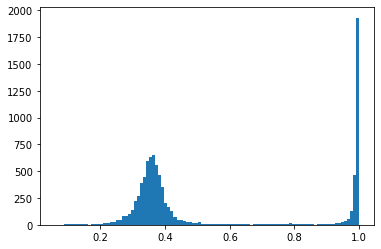

In [56]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [57]:
#%debug

In [58]:
#=====

# Predict and submit

In [59]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    preds = []
    for i, (images, _, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        with torch.no_grad():
            outputs, outputs2 = model(images)  # for MultiOutput
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
    
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return predictions

In [60]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None):
    model = eval(CFG.model_cls)()
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    is_add_ch=CFG.is_add_ch,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    for pth in pths:
        print("pth:", pth)
        
        # inference
        if predictions is None:
            predictions = inference(model, pth, test_loader, device, tta_transforms)
        else:
            predictions += inference(model, pth, test_loader, device, tta_transforms)

    test['preds'] = predictions / len(pths)
    
    return test

In [61]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [62]:
## ==========================================================
## valid inference
## ==========================================================
#seed = CFG.seeds[0]
#valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")
#
## tta inference
#pred_valid = pd.DataFrame()
#for fold in CFG.trn_fold:
#    print(f"===== valid fold{fold} =====")
#    
#    # model pths
#    pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
#    print(pths)
#    
#    valid_f = valid[valid.fold == fold]
#    print(valid_f.shape)
#    
#    valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#    
#    ## =============================
#    ## tta alb
#    ## =============================
#    #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
#    #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
#    #
#    #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
#    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
#    ## =============================
#    
#    # =============================
#    # tta Dataset
#    # =============================
#    _test_dataset = TrainDataset(valid_f, 
#                                 transforms=get_transforms(data="valid"),
#                                 #prob_spec_start_random=1.0,
#                                 #prob_vshift=1.0,  # CV悪化
#                                 prob_swap_nega=1.0,  # CV悪化
#                                 is_npy=CFG.is_npy,
#                                 is_add_ch=CFG.is_add_ch,
#                               )
#    valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
#    valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
#    
#    valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
#    valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
#    # =============================
#    
#    _ = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
#    pred_valid = pd.concat([pred_valid, valid_f])
#    
#tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
#pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta.csv', index=False)
#display(pred_valid.head())
#
##if CFG.is_wandb:
##    # save log wandb
##    wandb.log({f"TTA oof Score": tta_oof_score})

In [63]:
#%debug

['./output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold4_seed0_best_score.pth']
pth: ./output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold0_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.73it/s]


pth: ./output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold1_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.72it/s]


pth: ./output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold2_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.73it/s]


pth: ./output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold3_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.72it/s]


pth: ./output/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap/kqi_3090_ex075_pseudo_multioutput_freq_b5_ap_fold4_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.69it/s]


,id,freq min,freq max,H1 SFTs h,H1 SFTs w,H1 time min,H1 time max,H1 max inteval,L1 SFTs h,L1 SFTs w,L1 time min,L1 time max,L1 max inteval,target,path,orig,freq_min//10,h1_mean,l1_mean,h1_std,l1_std,h1_minstd,h1_maxstd,h1_stddiff,l1_minstd,l1_maxstd,l1_stddiff,h1_max/l1_max,preds
0,00054c878,306.402222,306.601667,360.0,4639.0,1.238170e+09,1.248567e+09,43102.0,360.0,4566.0,1.238169e+09,1.248561e+09,43102.0,0.294844,/workspace/g2net2/pyfstat_output/largekernel|p...,1,30.0,2.251338,2.247327,0.397542,0.397476,1.058791e-22,1.058791e-22,0.0,1.058791e-22,1.058791e-22,0.0,1.085967,0.294844
1,0007285a3,126.348889,126.548333,360.0,4427.0,1.238168e+09,1.248520e+09,42746.0,360.0,4650.0,1.238170e+09,1.248537e+09,42746.0,0.418387,/workspace/g2net2/pyfstat_output/largekernel|p...,1,12.0,2.250531,2.253083,0.399520,0.399918,1.058791e-22,1.058791e-22,0.0,1.058791e-22,1.058791e-22,0.0,0.971284,0.418387
2,00076c5a6,197.289444,197.488889,360.0,4599.0,1.238169e+09,1.248535e+09,55878.0,360.0,4633.0,1.238172e+09,1.248567e+09,55878.0,0.307932,/workspace/g2net2/pyfstat_output/largekernel|p...,1,19.0,2.249787,2.250360,0.399082,0.401004,1.058791e-22,1.058791e-22,0.0,1.058791e-22,1.058791e-22,0.0,1.037622,0.307932
3,001349290,94.908333,95.107778,360.0,4609.0,1.238171e+09,1.248536e+09,48020.0,360.0,4621.0,1.238167e+09,1.248537e+09,48020.0,0.396386,/workspace/g2net2/pyfstat_output/largekernel|p...,1,9.0,2.251309,2.250812,0.399954,0.399532,1.058791e-22,1.058791e-22,0.0,1.058791e-22,1.058791e-22,0.0,1.025819,0.396386
4,001a52e92,464.077222,464.276667,360.0,4601.0,1.238167e+09,1.248535e+09,45246.0,360.0,4366.0,1.238167e+09,1.248543e+09,45246.0,0.344182,/workspace/g2net2/pyfstat_output/largekernel|p...,1,46.0,2.250533,2.250065,0.402394,0.400455,1.058791e-22,1.058791e-22,0.0,1.058791e-22,1.058791e-22,0.0,0.976649,0.344182


target range [0.040214, 0.997908]


,id,target
0,00054c878,0.294844
1,0007285a3,0.418387
2,00076c5a6,0.307932
3,001349290,0.396386
4,001a52e92,0.344182
...,...,...
7970,ffbce04ef,0.968701
7971,ffc2d976b,0.283278
7972,ffc905909,0.260835
7973,ffe276f3e,0.337311


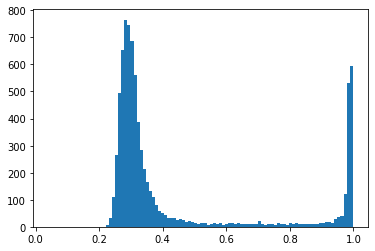

In [64]:
if IS_MAKE_SUB:
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
    print(pths)

    # ==========================================================
    # test inference
    # ==========================================================
    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")

    ## =============================
    ## tta alb
    ## =============================
    #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
    #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
    ## =============================

    submit["target"] = submit["preds"].to_numpy()
    display(submit.head())
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test.csv', index=False)
    
    submit = submit[["id", "target"]]
    print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

    # Write prediction
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv', index=False)
    display(submit)

    plt.hist(submit["target"], bins=100)
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()

In [65]:
if CFG.is_wandb:
    wandb.finish()

[fold0] avg_train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
[fold0] avg_val_loss,█▅▄▃▅▃▃▃▄▂▂▂▂▁▂▂▁▂▁▁▂▁▁▂▁▁▁▂▂▂▁▂▁▂▁▁▁▂▂▁
[fold0] epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
[fold0] lr,▃▆███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
[fold0] score,▁▆▇▇▇▇▇▇█▇█▇▇█▇███████▇▇██▇▇████████████
[fold1] avg_train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
[fold1] avg_val_loss,█▆▃▃▃▂▂▂▂▂▃▂▂▂▂▁▂▂▂▂█▂▁▁▂▁▂▂▂▁▁▁▂▂▂▂▁▂▂▂
[fold1] epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
[fold1] lr,▃▆███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
[fold1] score,▁▅▇▇▇██▇▇▇▇▇▇█▇▇▇█▇█▆▇██▇██▇▇██████████▇
[fold2] avg_train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁


In [66]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [67]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [68]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()